last edited on November 27 by Claire Valva
# Endless seasons for 40.5N spectral analysis

This notebook uses fft coefficient values (averaged for each season) to then create an arbitrarily long wave (ie. an endless summer etc) for later analysis.

To do: increase readability

In [1]:
#import packages
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import scipy
import matplotlib.pyplot as plt
from math import pi
import matplotlib.ticker as tck
import datetime
import pickle
from functions_forspectralanalysis import * #just in case I need it?
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.fourier import fourier_gaussian
from seaborn import cubehelix_palette
import copy
import pandas as pd
import seaborn as sns

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


In [2]:
#load 2d transform from last time
file_Name = "transform_2d_oct2018"
file_pickle = open(file_Name,'rb') 
loaded_pickle = pickle.load(file_pickle)

In [3]:
d2_trans, seasons, d2_averages, d2_averages_alt, d2_averages_alt_nw, d2_trans_nowind, d2_averages_nw, d2_stddev_nw = loaded_pickle

## write function to extend season length and test

### sort the longitudes into buckets

In [4]:
#set lists of longitude sections as strings for labeling
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

In [5]:
def lon_sort(lon):
    #define function to sort into longitude sections
    clon_1 = lon >= 50 and lon <= 140
    clon_2 = lon <= 50 or lon >= 320
    clon_3 = lon >= 230 and lon <= 320
    clon_4 = lon >= 140 and lon <= 230

    if clon_1 == True:
        return(1)
    elif clon_2 == True:
        return(2)
    elif clon_3 == True:
        return(3)
    elif clon_4 == True:
        return(4)
    else:
        return("lon sorting error")

In [6]:
#get beginning and end of each index
lon_index_sort = [[i for i in range(240) if lon_sort(i*1.5) == j + 1] for j in range(4)]
beginning_lons = [entry[0] for entry in lon_index_sort]
end_lons = [entry[len(entry) - 1] for entry in lon_index_sort]

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]

## write extended ifft

In [8]:
def ext_row(row, n):
    ext_f = np.zeros(((len(row) - 1) * n + 1,), dtype="complex128")
    ext_f[::n] = row * n
    
    return ext_f

In [9]:
def ext_ifft_new(n, input_array):
    #add the zeros onto each end
    ext_f = [ext_row(entry,n) for entry in input_array]
    
    #make up for the formulat multiplying for array length
    olddim = len(input_array[5])
    newdim = len(ext_f[0])
    mult = newdim/olddim
    
    #ext_f = np.multiply(mult, ext_f)
    adjusted_tested = np.fft.ifft2(ext_f)
    
    return adjusted_tested

## run ifft


In [10]:
run_fresh = False

In [11]:
if run_fresh == True:
    new_ifft_nw = [ext_ifft_new(200,entry) for entry in d2_averages_nw]
    new_ifft_nw_alt = [ext_ifft_new(200,entry) for entry in d2_averages_altok_nw]
    
    #try the one where I add back standard deviation
    random_scatter = [np.random.normal(loc=0.0, scale=entry) for entry in d2_stddev_nw]
    coeffs_withscatter = [np.add(random_scatter[i], d2_averages_nw[i]) for i in range(4)]
    #do the transform
    ifft_withscatter = [ext_ifft_new(400,entry) for entry in coeffs_withscatter]
    
    scatter2 = [np.random.normal(loc=0.0, scale=np.multiply(entry,2))
                for entry in d2_stddev_nw]
    coeffs_withscatter2 = [np.add(scatter2[i], d2_averages_nw[i]) for i in range(4)]
    withscatter2 = [ext_ifft_new(400,entry) for entry in coeffs_withscatter2]
    
    scatter15 = [np.random.normal(loc=0.0, scale=np.multiply(entry,1.5))
                for entry in d2_stddev_nw]
    coeffs_withscatter15 = [np.add(scatter15[i], d2_averages_nw[i]) for i in range(4)]
    withscatter15 = [ext_ifft_new(400,entry) for entry in coeffs_withscatter2]
    
    file_Name = "nov18_iffts"
    
    file_pickle = open(file_Name,'wb') 
    tosave = [ifft_withscatter, new_ifft_nw_alt, new_ifft_nw, withscatter2, withscatter15]
    
    pickle.dump(tosave,file_pickle)
    file_pickle.close()

In [12]:
#try the one where I add back standard deviation
random_scatter = [np.random.normal(loc=0.0, scale=entry) for entry in d2_stddev_nw]
for i in range(4):
    random_scatter[i][0][0] = 0
    
coeffs_withscatter = [np.add(random_scatter[i], d2_averages_nw[i]) for i in range(4)]

ifft_withscatter_nomean = [ext_ifft_new(400,entry) for entry in coeffs_withscatter]

In [13]:
#ifft_withscatter_nomean4 = ext_ifft_new(500,coeffs_withscatter[0])

In [14]:
#ifft_withscatter_nomean3 = ext_ifft_new(700,d2_averages_nw[0])

In [15]:
if run_fresh == False:
    #load 2d transform from last time
    file_Name = "nov18_iffts"
    
    file_pickle = open(file_Name,'rb') 
    ifft_withscatter, new_ifft_nw_alt, new_ifft_nw, withscatter2, withscatter15 = pickle.load(file_pickle)

## record stats about each distribution

In [16]:
def get_stats(name, data, season):
    #get test statistics and make into a dictionary
    mean = np.mean(data)
    median = np.median(data)
    variance = np.var(data)
    skew = scipy.stats.skew(data, axis = None)
    teststat, normtest = scipy.stats.normaltest(data, axis = None)
    kurtosis = scipy.stats.kurtosis(data, axis = None)
    top1 = np.percentile(data,99)
    top5 = np.percentile(data,95)
    bot1 = np.percentile(data,1)
    bot5 = np.percentile(data,5)
    
    newrow = {
        "name": name,
        "season": season,
        "mean": mean,
        "median":median,
        "variance":variance,
        "skew":skew,
        "normtest": normtest,
        "kurt":kurtosis,
        "top1":top1,
        "top5":top5,
        "bot1":bot1,
        "bot5":bot5
    }
    
    return newrow

#make empty list to append rows to
rows_list = []

## look at ifft of means

In [17]:
#get mean of each season
real_comp = [np.real(entry) for entry in new_ifft_nw]
nw_mean_seasons = [np.average(entry) for entry in real_comp]

In [18]:
#get locations of top and bottom percentiles
top = [np.percentile(real_comp[j], 95) for j in range(4)]
top_lons = [[i for i in range(len(real_comp[j])) 
             for entry in real_comp[j][i]  
            if entry > top[j]] 
            for j in range(4)]

bot = [np.percentile(real_comp[j], 5) for j in range(4)]
bot_lons = [[i for i in range(len(real_comp[j])) 
             for entry in real_comp[j][i]  
            if entry < bot[j]] 
            for j in range(4)]

In [19]:
for i in range(4):
    rows_list.append(get_stats("simdata_nonoise",real_comp[i], seasons[i]))

In [20]:
flattened = [flatten(entry) for entry in real_comp]

In [21]:
minx = 8000
maxx = 10000

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

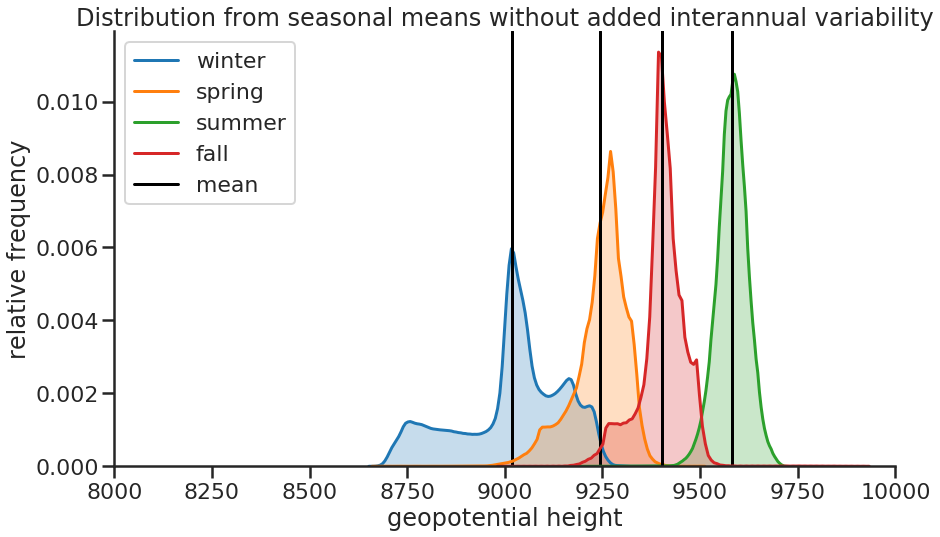

In [22]:
plt.clf();
plt.figure(figsize = (14,8))
sns.set_style("ticks")
sns.set_context("poster")

for i in range(4):
    sns.kdeplot(flattened[i], shade = True, label = seasons[i])
    plt.axvline(nw_mean_seasons[i], color = "black")

#sns.kdeplot(flattened[i], shade=True)
plt.xlabel("geopotential height")
plt.axvline(nw_mean_seasons[i], label = "mean", color = "black")
plt.ylabel("relative frequency")
plt.legend()
sns.despine()
plt.xlim(xmin = minx, xmax = maxx)
plt.title("Distribution from seasonal means without added interannual variability")

name = "disp_plots/presentation/01_sim_nonoise_all.png"
plt.savefig(name, bbox_inches = "tight")

plt.show()

## use data with added noise

In [23]:
#get mean with noise
real_noise_nm = [np.real(entry) for entry in ifft_withscatter_nomean]
noise_means_nm = [np.average(entry) for entry in real_noise_nm]

In [24]:
#get locations of top and bottom percentiles
noise_top = [np.percentile(real_noise_nm[j], 95) for j in range(4)]
noise_top_lons = [[i for i in range(len(real_noise_nm[j])) 
             for entry in real_noise_nm[j][i]  
            if entry > noise_top[j]] 
            for j in range(4)]

noise_bot = [np.percentile(real_noise_nm[j], 5) for j in range(4)]
noise_bot_lons = [[i for i in range(len(real_noise_nm[j])) 
             for entry in real_noise_nm[j][i]  
            if entry < noise_bot[j]] 
            for j in range(4)]

In [25]:
for i in range(4):
    rows_list.append(get_stats("simdata_noise",real_noise_nm[i], seasons[i]))

In [26]:
flattened_noise = [flatten(entry) for entry in real_noise_nm]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

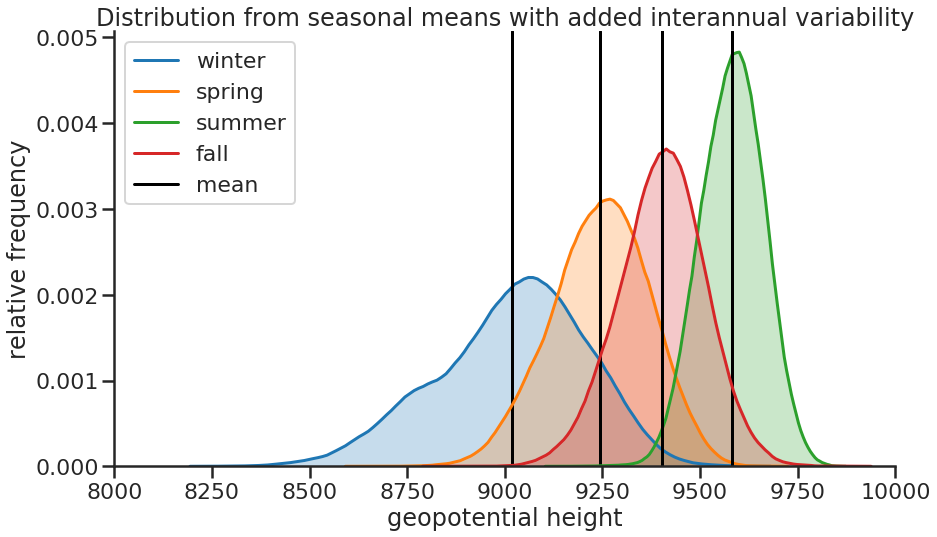

In [27]:
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    sns.kdeplot(flattened_noise[i], shade = True, label = seasons[i])
    plt.axvline(noise_means_nm[i], color = "black")
plt.xlabel("geopotential height")
plt.axvline(noise_means_nm[i], label = "mean", color = "black")
plt.ylabel("relative frequency")
plt.legend()
plt.xlim(xmin = minx, xmax = maxx)
sns.set_style("ticks")
sns.set_context("poster")
plt.title("Distribution from seasonal means with added interannual variability")
sns.despine()

name = "disp_plots/presentation/01_sim_noise_all.png"
plt.savefig(name, bbox_inches = "tight")

plt.show()

## compare to original histograms

In [27]:
avg4_df = pd.read_pickle('avg4_df.pickle')
geopot_df = pd.read_pickle('geopot_df.pickle')

In [28]:
#drop the duplicates of the imported dataframes
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["geopotential", "climatological-mean geopotential"]

In [29]:
lon_sectioned = [[np.array(entry[beginning_lons[j]:end_lons[j]]) for j in range(4)]
                      for entry in real_noise_nm]
mean_lons = [[np.average(entry) for entry in season] for season in lon_sectioned]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

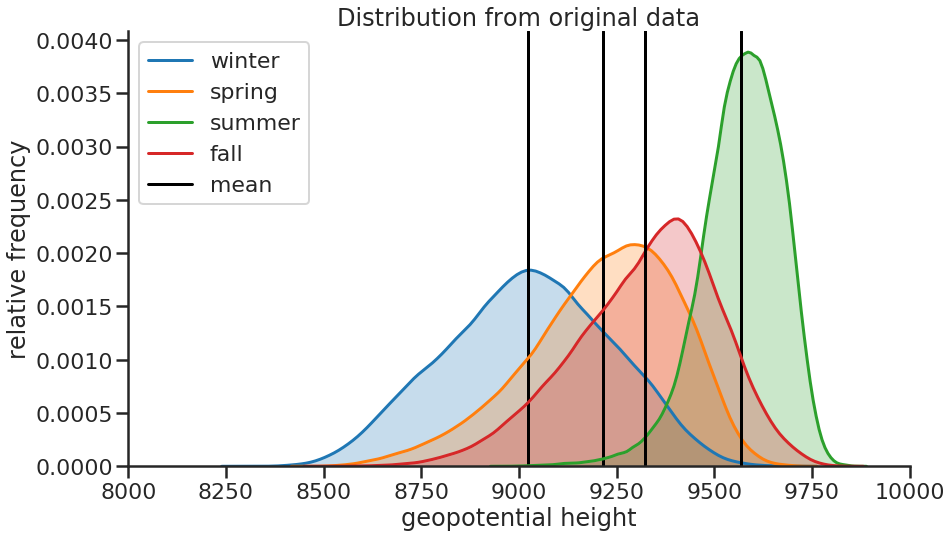

In [30]:
#make this for the original data as well
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    season = seasons[i]
    #get from simmed data
    #to_section = lon_sectioned[i]
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]
    
    sns.kdeplot(plot_df['geofrom_climmonth'], shade = True, label = seasons[i])
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color = "black")

plt.xlabel("geopotential height")
plt.axvline(plot_df['geofrom_climmonth'].mean(), label = "mean", color = "black")
plt.ylabel("relative frequency")
plt.legend()
plt.title("Distribution from original data")
plt.xlim(xmin = minx, xmax = maxx)

sns.set_style("ticks")
sns.set_context("poster")
sns.despine()

name = "disp_plots/presentation/01_obs_all.png"
plt.savefig(name, bbox_inches = "tight")
plt.show()

In [31]:
#get locations of top and bottom percentiles
obs_top = [np.percentile(day_df[day_df["season"] == season]['geofrom_climmonth'], 95)
           for season in seasons]
obs_bot = [np.percentile(day_df[day_df["season"] == season]['geofrom_climmonth'], 5)
           for season in seasons]

In [32]:
observed_list = [list(day_df[day_df["season"] == seasons[j]]['geofrom_climmonth']) 
                 for j in range(4)]
lon_list = [list(day_df[day_df["season"] == seasons[j]]['lon']) 
                 for j in range(4)]

In [33]:
obs_top_lons = [[lon_list[j][i] for i in range(len(lon_list[j]))
                if observed_list[j][i] > obs_top[j]] 
                for j in range(4)] 

obs_bot_lons = [[lon_list[j][i] for i in range(len(lon_list[j]))
                if observed_list[j][i] < obs_bot[j]] 
                for j in range(4)] 

## compare longitudinal structures of extreme events
(from with and without noise)

In [34]:
season_label = ["Winter", "Spring", "Summer", "Fall"]

In [ ]:
##plot for display purposes

plt.clf()


fig, ax = plt.subplots(nrows=4, ncols=2, sharex='col', sharey='row', figsize=(15,15))

fig.suptitle("Longitudinal structure of extreme events")

for row in range(len(ax)):
    for col in range(len(ax[row])):
        
        if col == 1:
            ax[row][col].hist(obs_bot_lons[i], 
                 label = "observed data", 
                 bins = 30, alpha = 0.6, density = True)
            ax[row][col].hist(noise_bot_lons[i], 
                 label = "reconstruction with noise", 
                 bins = 30, alpha = 0.6, density = True)
            ax[row][col].hist(bot_lons[i], 
                 label = "reconstruction without noise", 
                 bins = 20, alpha = 0.6, density = True)
            
        if col == 0:
            ax[row][col].hist(obs_top_lons[i], 
                 label = "observed data", 
                 bins = 30, alpha = 0.6, density = True)
            ax[row][col].hist(noise_top_lons[i], 
                 label = "reconstruction with noise", 
                 bins = 30, alpha = 0.6, density = True)
            ax[row][col].hist(top_lons[i], 
                 label = "reconstruction without noise", 
                 bins = 20, alpha = 0.6, density = True)
        
        ax[row][col].set_title(season_label[row])
        
            

#ax[0][0].set_title("High geopotential height extremes")
#ax[0][1].set_title("Low geopotential height extremes")
ax[3][1].legend(loc=9, bbox_to_anchor=(0.5, -0.3))

# Set common labels
fig.text(0.5, 0.08, 'Longitude (East)', ha='center', va='center')
fig.text(0.04, 0.5, 'Relative frequency', ha='center', va='center', rotation='vertical')

sns.despine()

name = "disp_plots/presentation/01_longstruct.png"
plt.savefig(name, bbox_inches = "tight")

#plt.show()

## Compare distributions of geopotential height

In [35]:
def compare_plot(i):
    season = seasons[i]
    #get from simmed data
    to_section = lon_sectioned[i]
    flat_season = flatten(real_noise_nm[i])
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]

    minx = np.min(plot_df['geofrom_climmonth'])
    maxx = np.max(plot_df['geofrom_climmonth'])
    
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title("geopotential height for extended " + seasons[i])
    plt.hist(flat_season, 
             bins = 100, density = True, alpha = 0.5, label = "simulated")
    plt.hist(plot_df['geofrom_climmonth'], bins = 60, alpha = .5, density = True, label = "original")
    plt.axvline(noise_means[i])
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color='orange')
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.legend()
    plt.show()
    
    


    for j in range(4):
        
        #get the correct original dataframe
        section_df = plot_df.query(lon_sections[j])
        
        plt.clf()
        plt.figure(figsize=(8,8))
        plt.hist(flatten(to_section[j]), bins = 100, 
                 density = True, alpha = 0.5,
                 label = "simulated")
        plt.hist(section_df['geofrom_climmonth'], bins = 60, alpha = .5,
                density = True, label = "original")
        plt.axvline(mean_lons[i][j])
        plt.axvline(section_df['geofrom_climmonth'].mean(), color='orange')
        plt.xlim(xmin = minx, xmax = maxx)
        plt.legend()
        plt.title(lon_sections[j])
        plt.xlabel('geopotential height')
        plt.ylabel('relative frequency')
        plt.show()

In [36]:
def compare_plotnm(i):
    sns.set_style("ticks")
    sns.set_context("poster")
    
    season = seasons[i]
    #get from simmed data
    to_section = lon_sectioned[i]
    flat_season = flattened_noise[i]
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]

    minx = np.min(plot_df['geofrom_climmonth'])
    maxx = np.max(plot_df['geofrom_climmonth'])
    
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title(season_label[i])
    
    sns.kdeplot(plot_df['geofrom_climmonth'], shade = True, label = "observed")
    plt.axvline(plot_df['geofrom_climmonth'].mean())
    
    sns.kdeplot(flat_season, shade = True, label = "simulated")
    plt.axvline(np.average(flat_season), color = "orange")
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.legend()
    sns.despine()
    
    name = "disp_plots/presentation/01_compsim_" + seasons[i] + ".png"
    plt.savefig(name, bbox_inches = "tight")
    plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

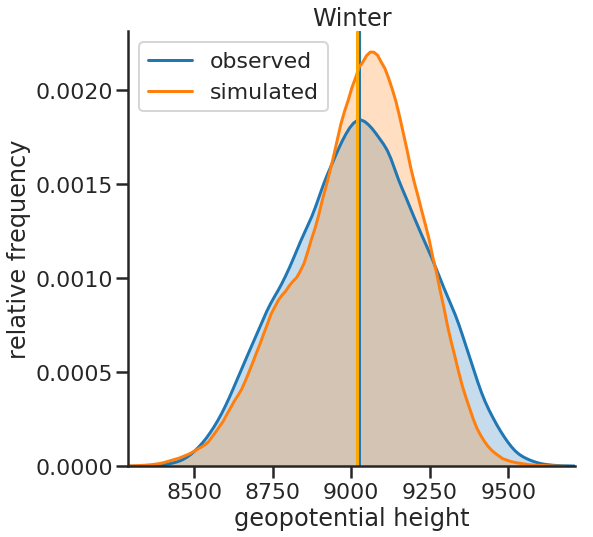

<Figure size 432x288 with 0 Axes>

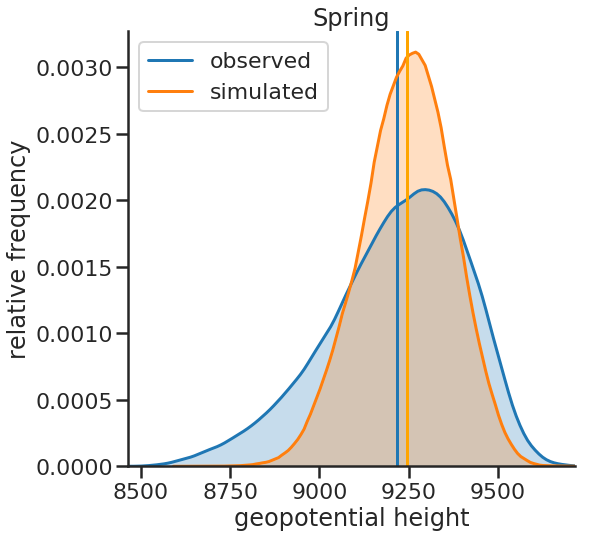

<Figure size 432x288 with 0 Axes>

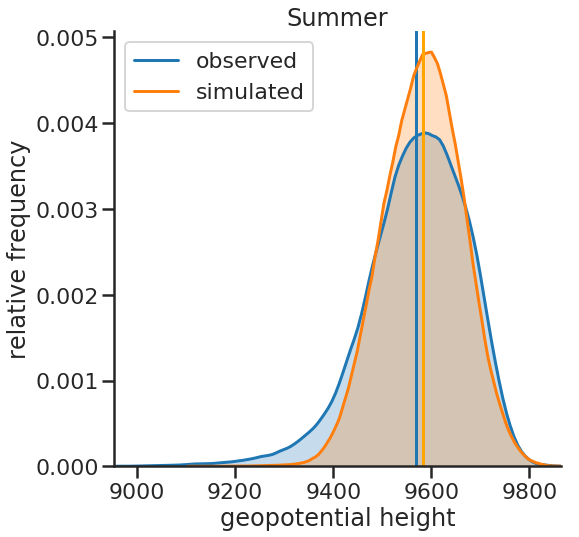

<Figure size 432x288 with 0 Axes>

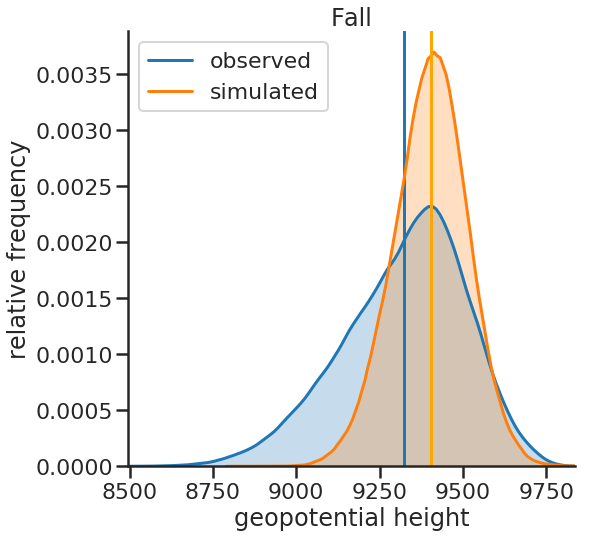

In [39]:
for i in range(4):
    compare_plotnm(i)

In [37]:
def compare_plotnm2(i):
    sns.set_style("ticks")
    sns.set_context("poster")
    
    season = seasons[i]
    #get from simmed data
    to_section = lon_sectioned[i]
    flat_season = flattened[i]
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]

    minx = np.min(plot_df['geofrom_climmonth'])
    maxx = np.max(plot_df['geofrom_climmonth'])
    
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title(season_label[i])
    
    sns.kdeplot(plot_df['geofrom_climmonth'], shade = True, label = "observed")
    plt.axvline(plot_df['geofrom_climmonth'].mean())
    
    sns.kdeplot(flat_season, shade = True, label = "simulated")
    plt.axvline(np.average(flat_season), color = "orange")
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.legend()
    
    sns.set_style("ticks")
    sns.set_context("poster")
    
    sns.despine()
    
    name = "disp_plots/presentation/01_compsim_nonoise" + seasons[i] + ".png"
    plt.savefig(name, bbox_inches = "tight")
    plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

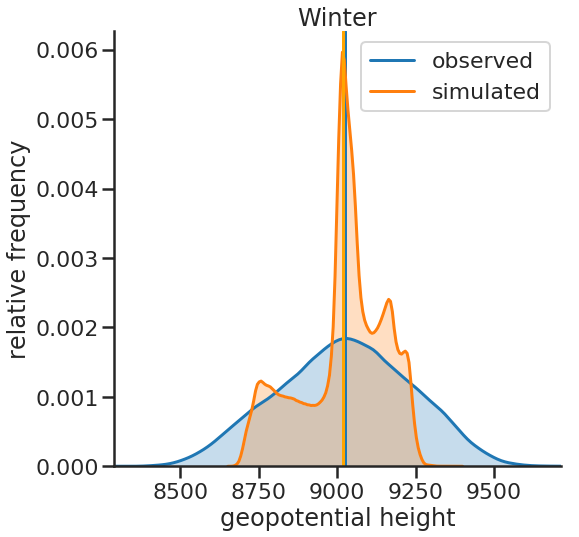

<Figure size 432x288 with 0 Axes>

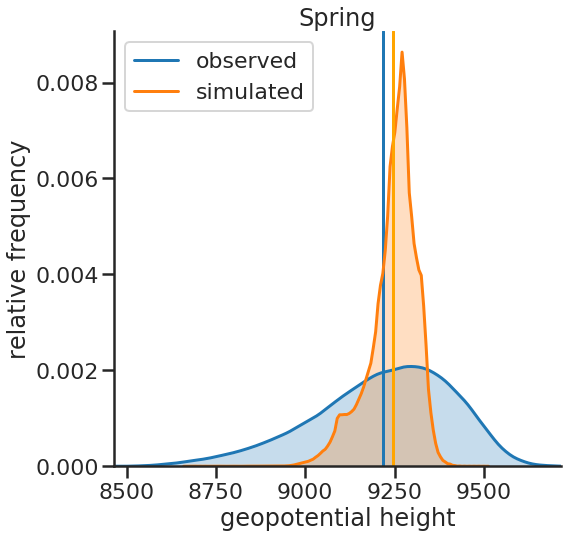

<Figure size 432x288 with 0 Axes>

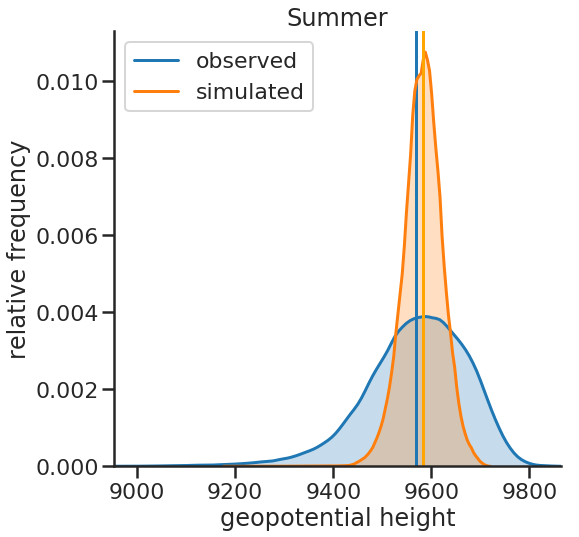

<Figure size 432x288 with 0 Axes>

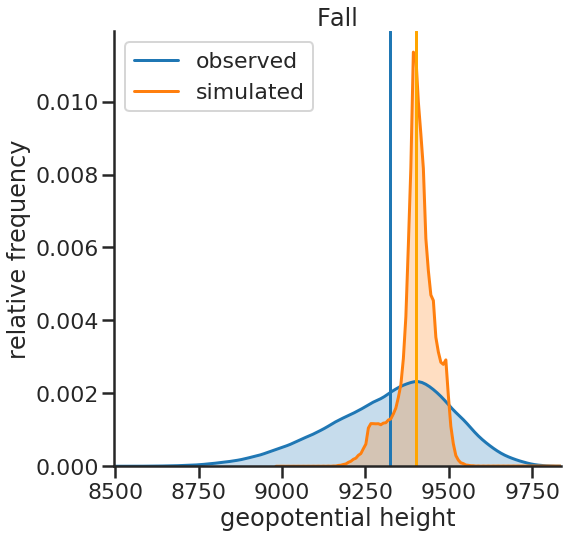

In [41]:
for i in range(4):
    compare_plotnm2(i)

## try filtering of spectra

In [38]:
def f_filter(array, upper, lower):
    #filters certain parts of the spectra out
    
    arrl = len(array[0])
    seasonf = fftfreq(arrl, 0.25)
    
    for j in range(len(array)):
        for i in range(len(array[0])):
            if np.abs(seasonf[i]) != 0 and np.abs(seasonf[i]) <= upper and np.abs(seasonf[i]) >= lower:
                array[j][i] = 0
    
    return array

In [39]:
zonal_spacing

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119., -120., -119., -118., -117., -116., -115.,
       -114., -113.,

In [41]:
def z_filter(array, upper, lower):
    #filters certain parts of the spectra out
    
    arrl = len(array[0])
    
    for j in range(len(array)):
        for i in range(len(array[0])):
            if np.abs(zonal_spacing[j]) != 0 and np.abs(zonal_spacing[j]) <= upper and np.abs(zonal_spacing[j]) >= lower:
                array[j][i] = 0
    
    return array

In [42]:
def ifft_withf(array, fupper_array, flower_array, n = 400):
    #filters spectra and then returns ifft
    empty = []
    
    if len(upper_array) != len(lower_array):
        return("error: length of upper bounds and lower bounds don't match.")
    
    for i in range(len(upper_array)):
        use = copy.deepcopy(array)
        filtered = f_filter(use, upper = fupper_array[i], lower = flower_array[i])
        trans = ext_ifft_new(n, filtered)
        empty.append(trans)
        
    return empty

In [43]:
def shorterf(array, fupper_array, flower_array, zupper_array = 400, zlower_array = -400, n = 400):
    use = copy.deepcopy(array)
    filtered = f_filter(use, fupper_array, lower = flower_array)
    filtered2 = z_filter(filtered, zupper_array, lower = zlower_array)
    trans = ext_ifft_new(n, filtered2)
    
    return(trans)

In [44]:
#change this to the one without the mean stuff??
edits = copy.deepcopy(coeffs_withscatter)

In [ ]:
#get filtering spectra
approx_freqs = np.abs(fftfreq(364, 0.25))
percents = [np.percentile(approx_freqs, i*5) for i in range(1,21)]

upper = [1,50]
lower = [0,1]

for i in range(len(percents)- 1):
    upper.append(percents[i + 1])
    lower.append(percents[i])

In [51]:
upper[1]

50

In [52]:
lower[1]

1

In [ ]:
edits

In [53]:
return1 = [shorterf(entry, upper[1], lower[1], n = 400) for entry in edits]
return1 = [np.real(entry) for entry in return1]

file_Name = "01_filter"
    
file_pickle = open(file_Name,'wb') 
    
pickle.dump(return1,file_pickle)
file_pickle.close()

In [54]:
for i in range(4):
    rows_list.append(get_stats("simdata_1gone",return1[i], seasons[i]))

In [45]:
flat_seasons = [flatten(entry) for entry in real_noise_nm]

In [46]:
#write plotting function:
def compare_filter(i,filtered, upper = None, lower = None, name = None):
    season = seasons[i]
    flat_season = flat_seasons[i]
    flat_filt = flatten(filtered)
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]

    minx = 8000
    maxx = 10000
  
    if upper == None:
        title = "geopotential height for extended " + seasons[i]
    else:
        title = "geopotential height for extended " + seasons[i] + ", range filtered = " + str(upper) + "to" + str(lower) 
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title(title)
    
    sns.kdeplot(plot_df['geofrom_climmonth'], shade = True, label = "observed")
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color = "black")
    
    sns.kdeplot(flat_season, shade = True, label = "simulated, unfiltered")
    plt.axvline(np.average(flat_season), color = "black")
    
    sns.kdeplot(flat_filt, shade = True, label = "simulated, filtered")
    plt.axvline(np.average(flat_filt), color = "black")
    
    
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.legend()
    
    sns.set_style("ticks")
    sns.set_context("poster")
    
    sns.despine()
    
    if i == 0:
        plt.savefig(name, bbox_inches = "tight")
    plt.show()

In [ ]:
return1 = [shorterf(entry, upper[1], lower[1], n = 400) for entry in edits]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

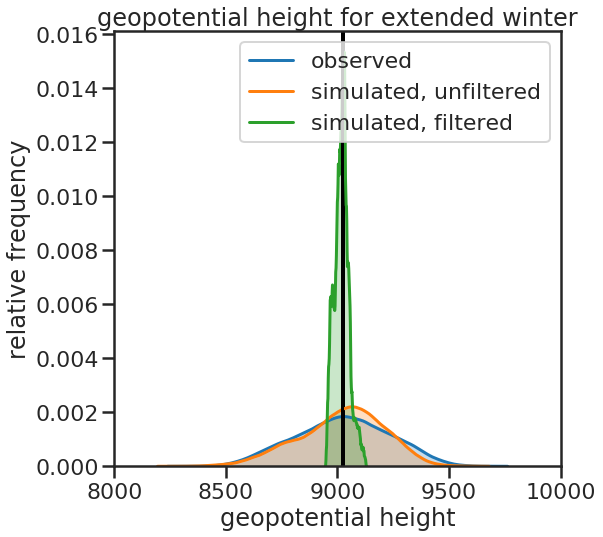

In [65]:
compare_filter(0, return1[0], name = "disp_plots/presentation/01_filter1.png")

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

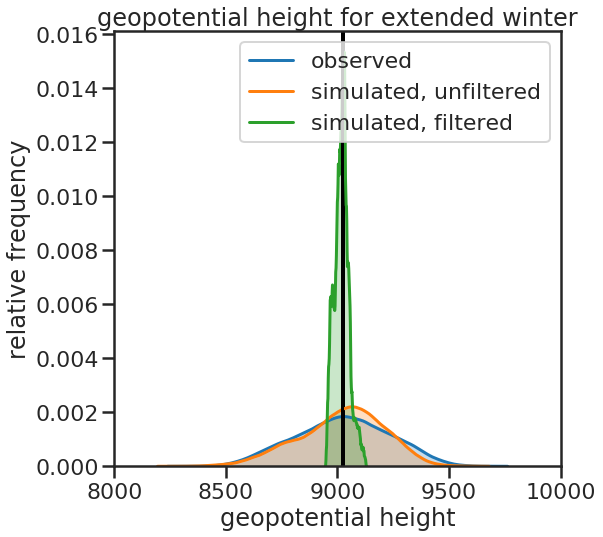

<Figure size 432x288 with 0 Axes>

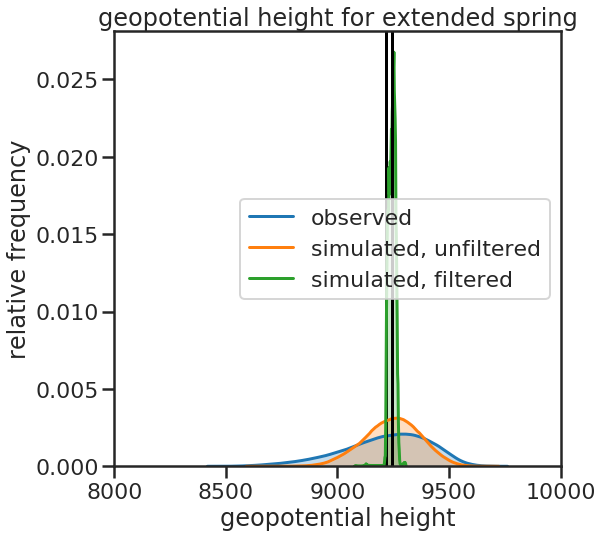

<Figure size 432x288 with 0 Axes>

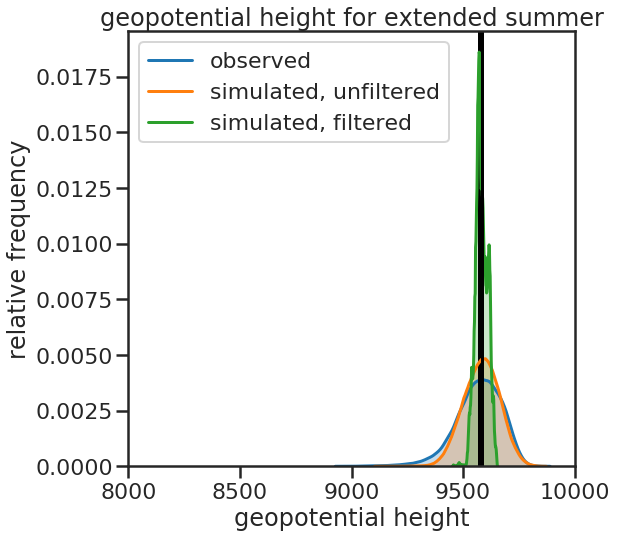

<Figure size 432x288 with 0 Axes>

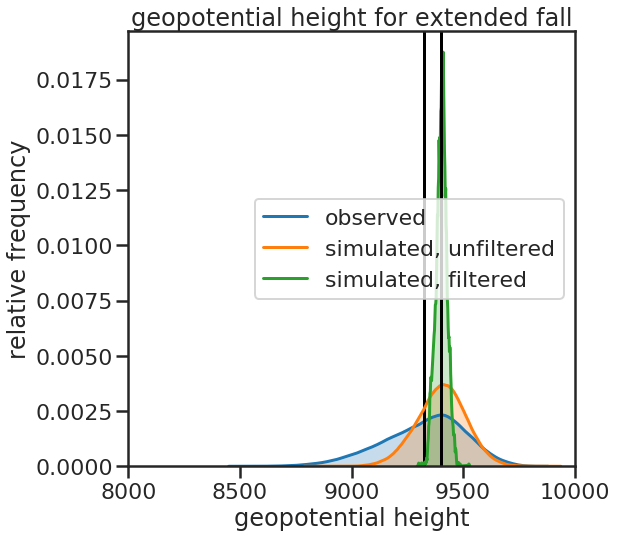

In [57]:
for i in range(4):
    compare_filter(i, return1)

In [59]:
fup = 0.5
flow = -5
zup = 15
zlow = -500

return2 = [shorterf(entry, fup, flow, zup, zlow, n = 400) for entry in edits]

file_Name = "02_filter"
    
file_pickle = open(file_Name,'wb') 
    
pickle.dump(return2[0],file_pickle)
file_pickle.close()

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

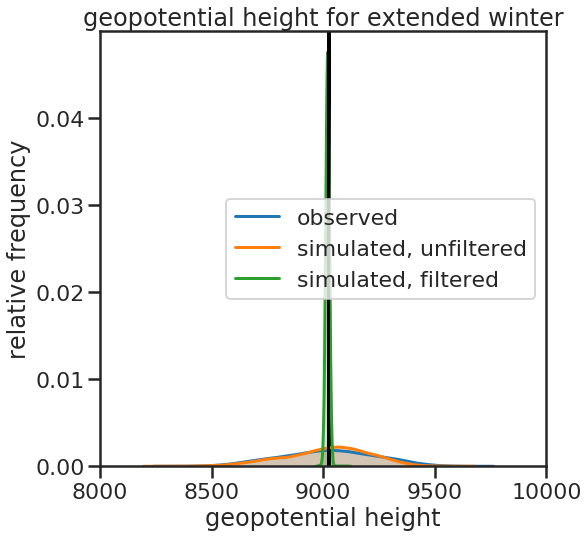

In [66]:
compare_filter(0, return2, name = "disp_plots/presentation/01_filter2.png")

In [47]:
fup = -5
flow = 5
zup = -500
zlow = 7

return3 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)



/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

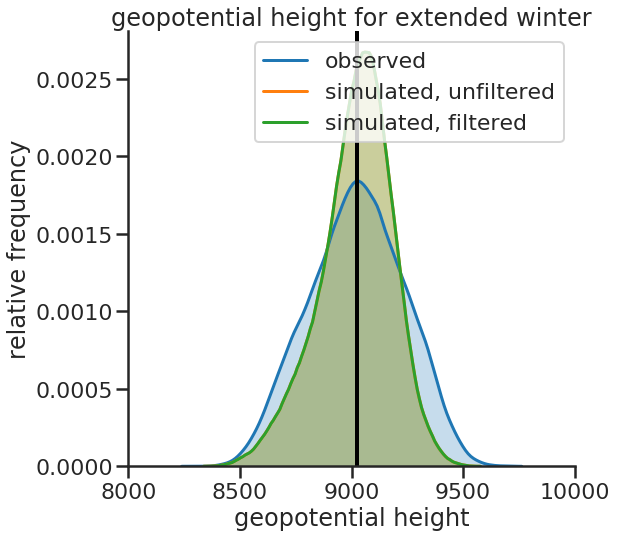

In [48]:
compare_filter(0, return3, name = "disp_plots/presentation/01_filter3.png")

In [ ]:
for i in range(4):
    compare_filter(i, return3)

In [59]:
flow = 0
fup = 1
zlow = 500
zup = 0

return6 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

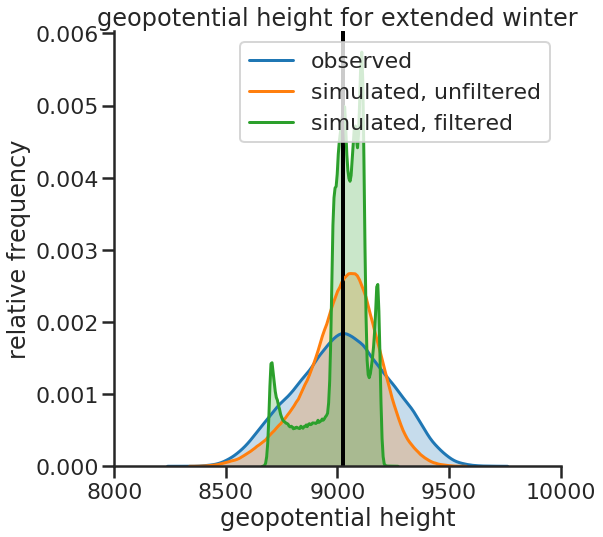

In [60]:
compare_filter(0, return6, name = "disp_plots/presentation/01_filter6.png")

In [61]:
flow = 1
fup = 2
zlow = 500
zup = 0

return5 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

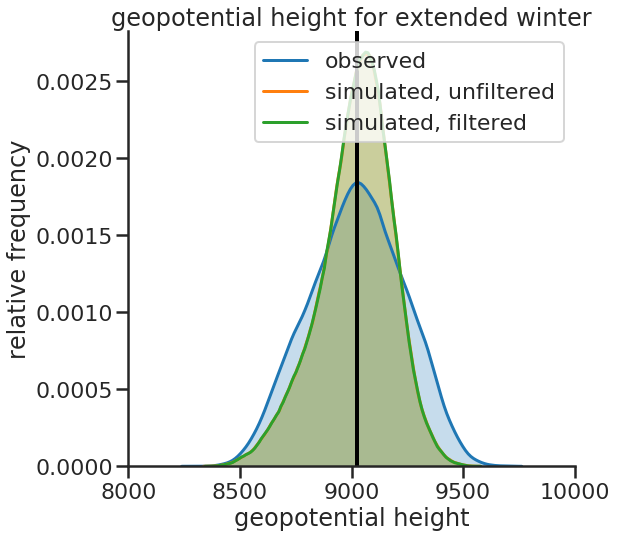

In [63]:
compare_filter(0, return5, name = "disp_plots/presentation/01_filter5.png")

In [64]:
flow = 0.1
fup = 2
zlow = 500
zup = 0

return4 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

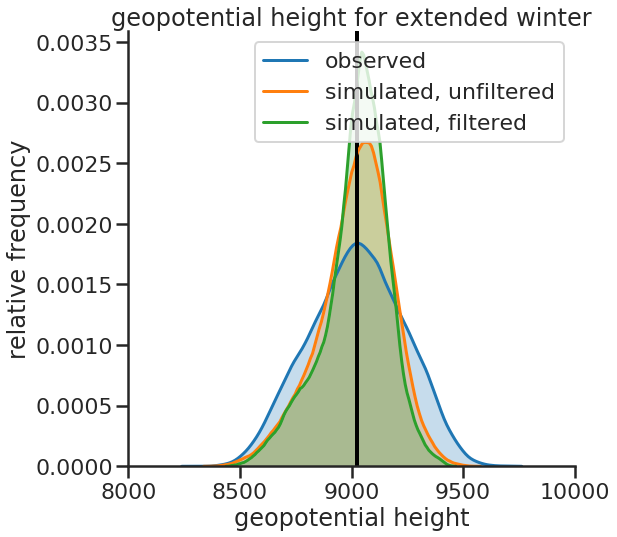

In [65]:
compare_filter(0, return4, name = "disp_plots/presentation/01_filter4.png")

In [66]:
fup = -5
flow = 5
zup = 300
zlow = 7

return5 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

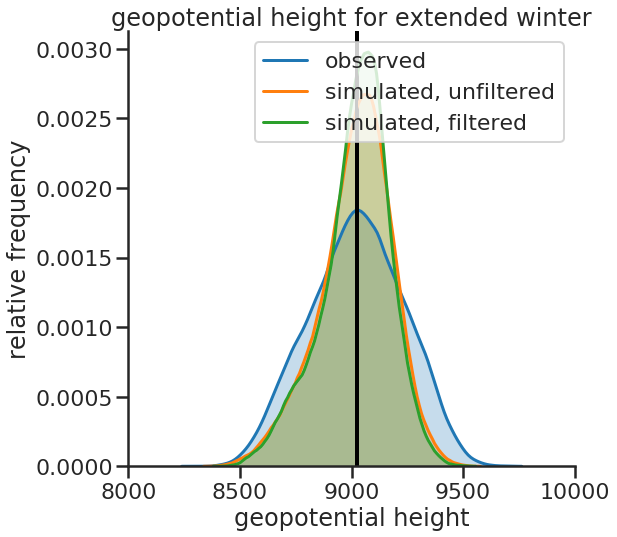

In [67]:
compare_filter(0, return5, name = "disp_plots/presentation/01_filter10.png")

In [ ]:
flow = 1
fup = 2
zlow = 7
zup = 200

return4 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

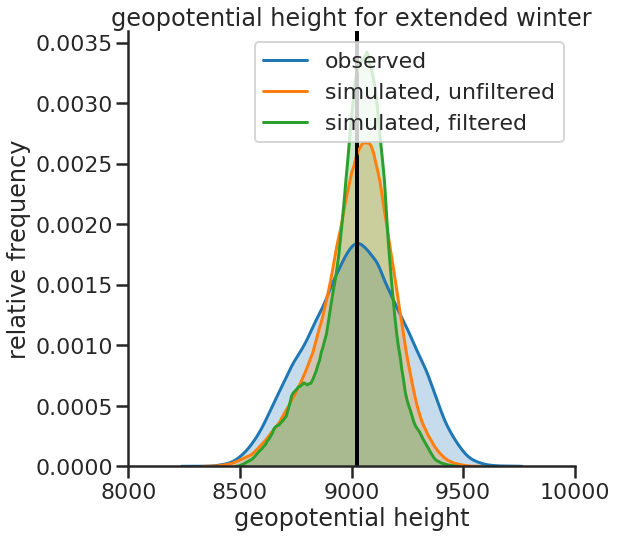

In [69]:
fup = 2
flow = 0.1
zup = 300
zlow = 7

return8 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

compare_filter(0, return8, name = "disp_plots/presentation/01_filter8.png")

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

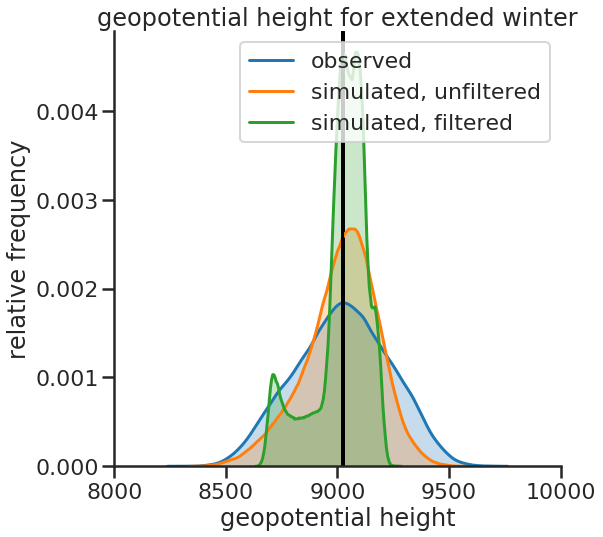

In [75]:
fup = 0.5
flow = 0
zup = 0
zlow = 10

return9 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

compare_filter(0, return9, name = "disp_plots/presentation/01_filter9.png")

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/clairev/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  data = data.astype(np.float64)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

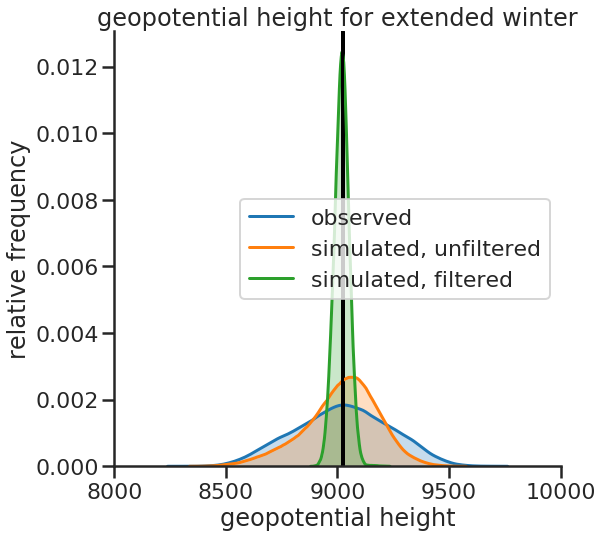

In [73]:
fup = -600
flow = 500
zup = 10
zlow = 0

return11 = shorterf(edits[0], fup, flow, zup, zlow, n = 400)

compare_filter(0, return11, name = "disp_plots/presentation/01_filter11.png")

<Figure size 432x288 with 0 Axes>

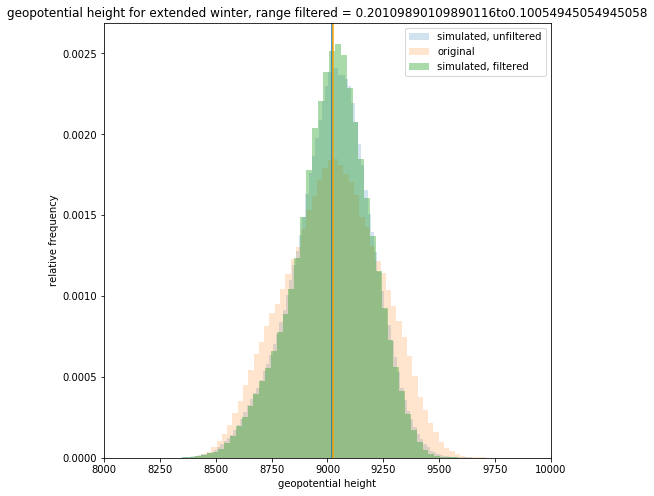

<Figure size 432x288 with 0 Axes>

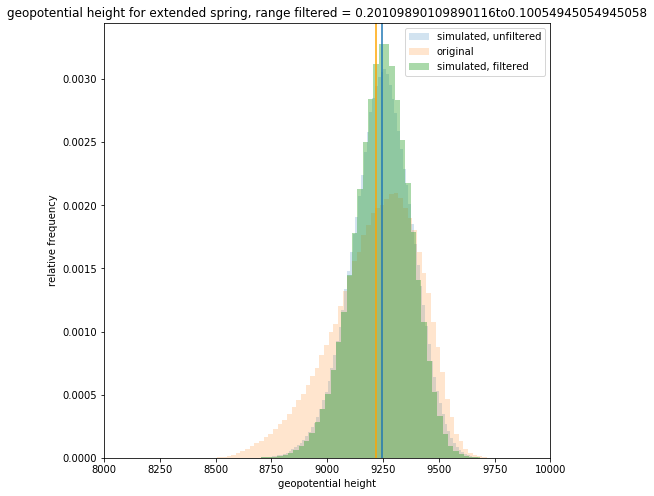

<Figure size 432x288 with 0 Axes>

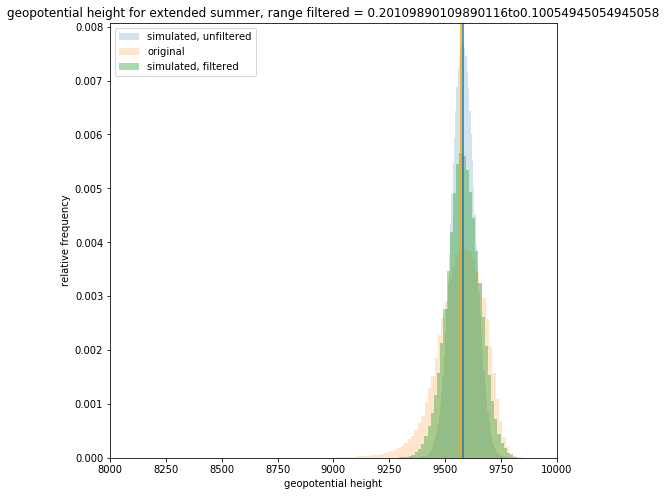

<Figure size 432x288 with 0 Axes>

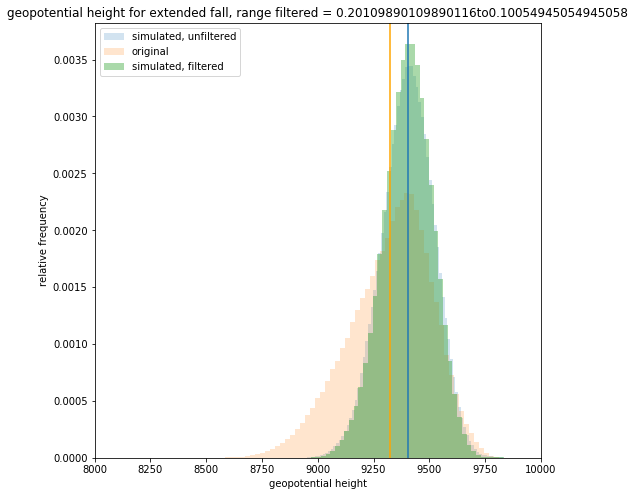

In [57]:
upps = upper[2]
lows = lower[2]

return2 = [shorterf(entry, upps, lows, n = 400) for entry in edits]
return2 = [np.real(entry) for entry in return2]

for i in range(4):
    compare_filter(i, return2, upps, lows)
    rows_list.append(get_stats("filter_"+str(upps)+"to"+str(lows), return2[i], seasons[i]))

<Figure size 432x288 with 0 Axes>

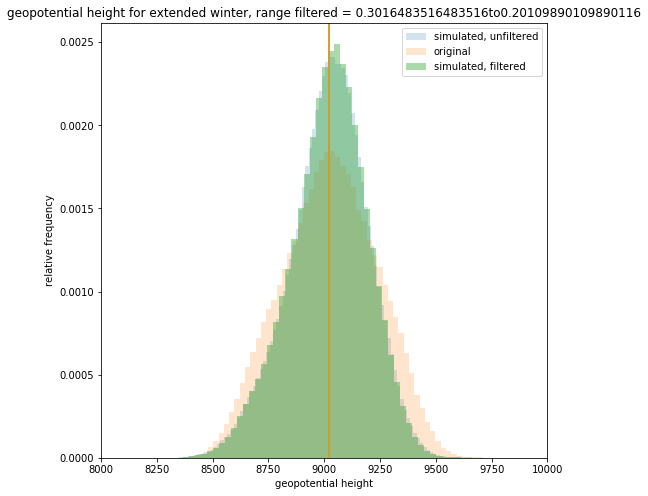

<Figure size 432x288 with 0 Axes>

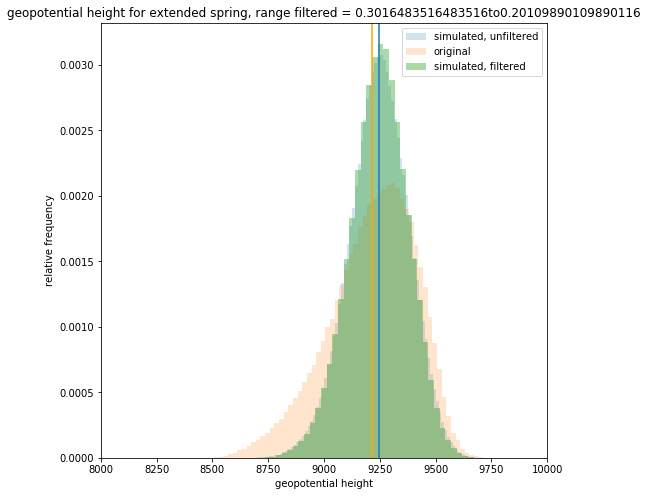

<Figure size 432x288 with 0 Axes>

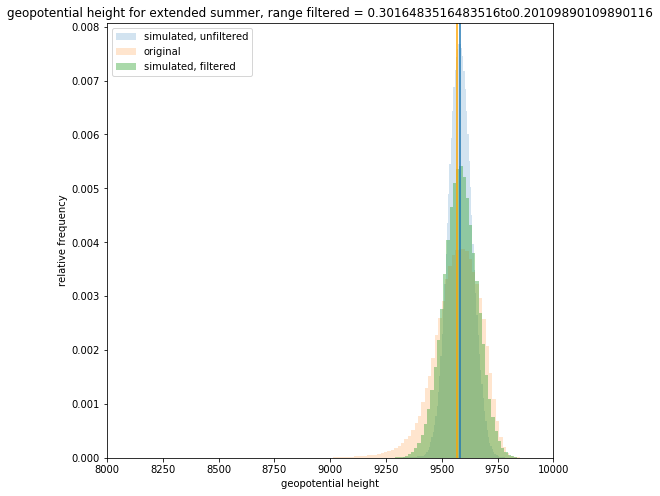

<Figure size 432x288 with 0 Axes>

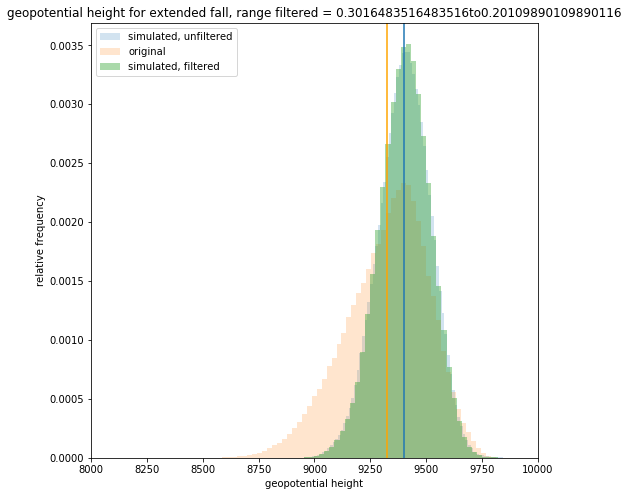

<Figure size 432x288 with 0 Axes>

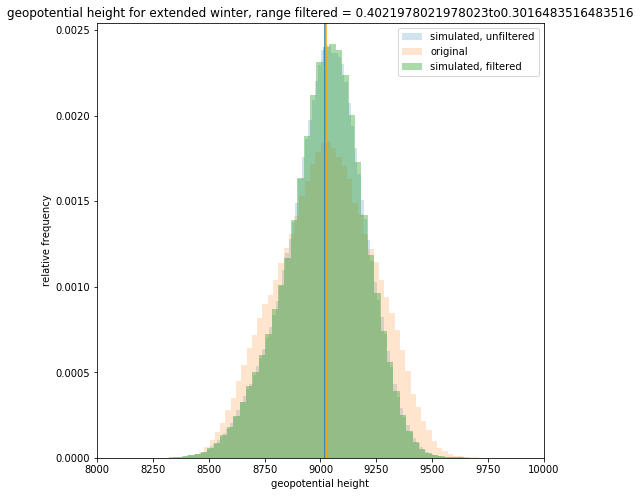

<Figure size 432x288 with 0 Axes>

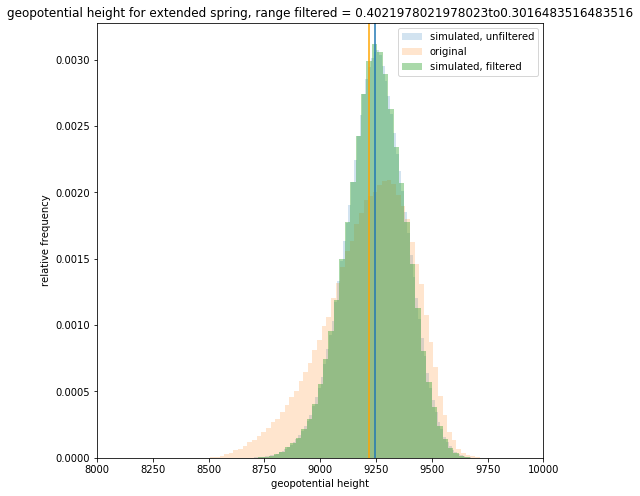

<Figure size 432x288 with 0 Axes>

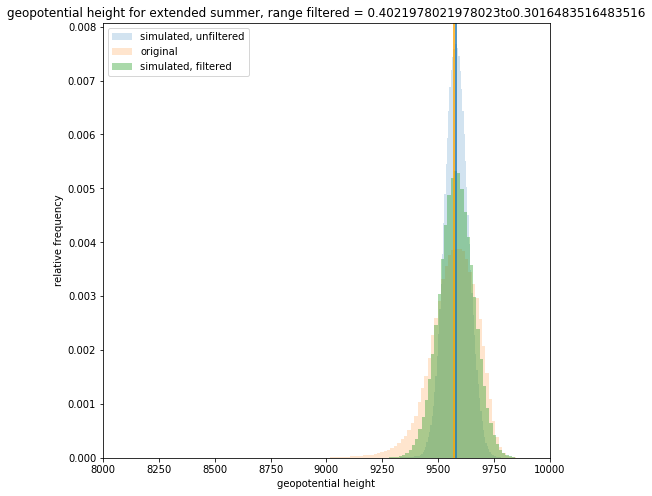

<Figure size 432x288 with 0 Axes>

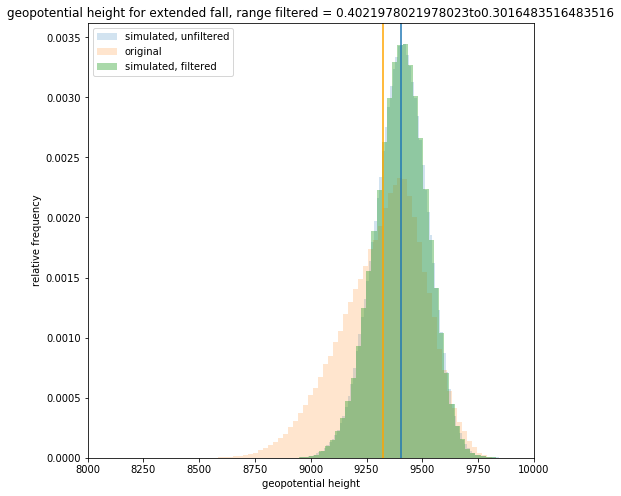

<Figure size 432x288 with 0 Axes>

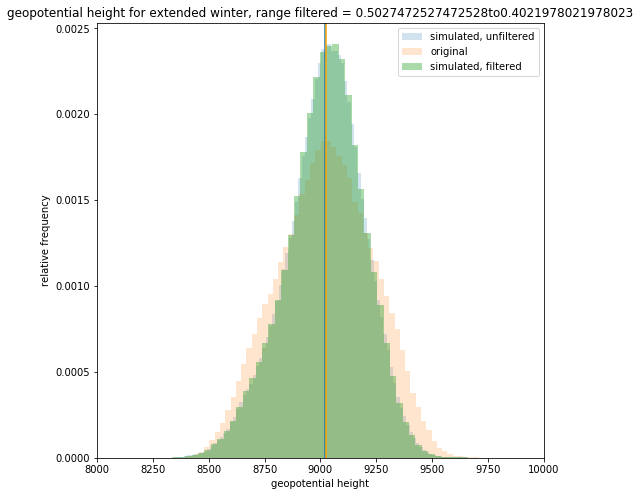

<Figure size 432x288 with 0 Axes>

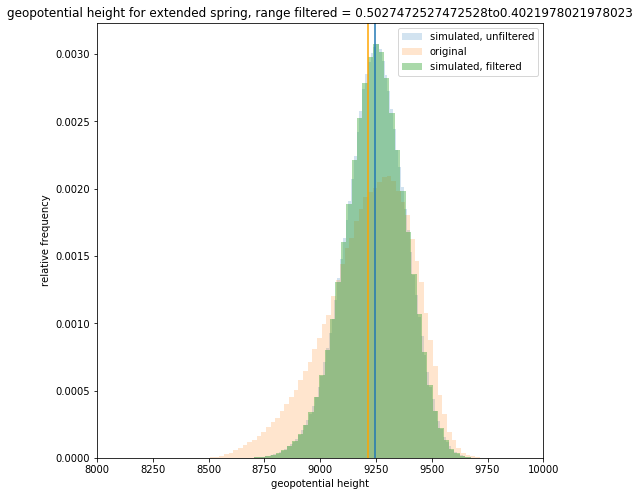

<Figure size 432x288 with 0 Axes>

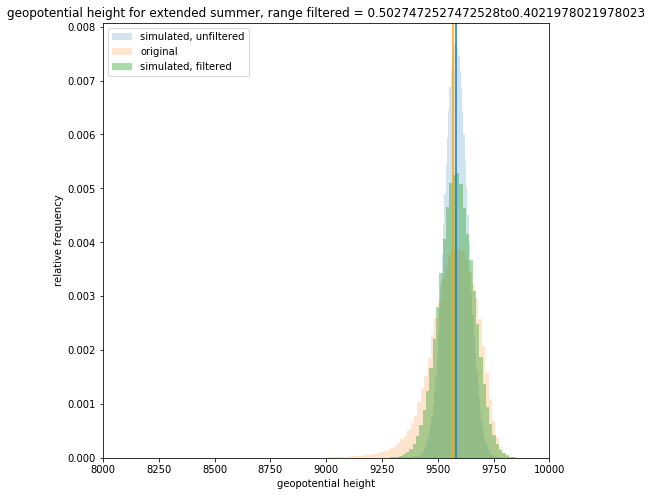

<Figure size 432x288 with 0 Axes>

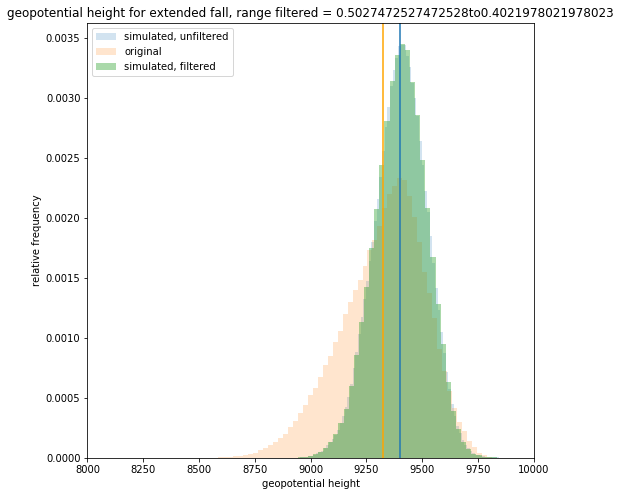

<Figure size 432x288 with 0 Axes>

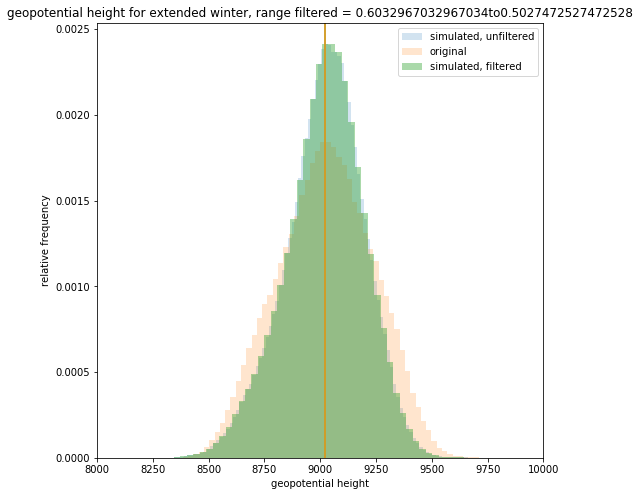

<Figure size 432x288 with 0 Axes>

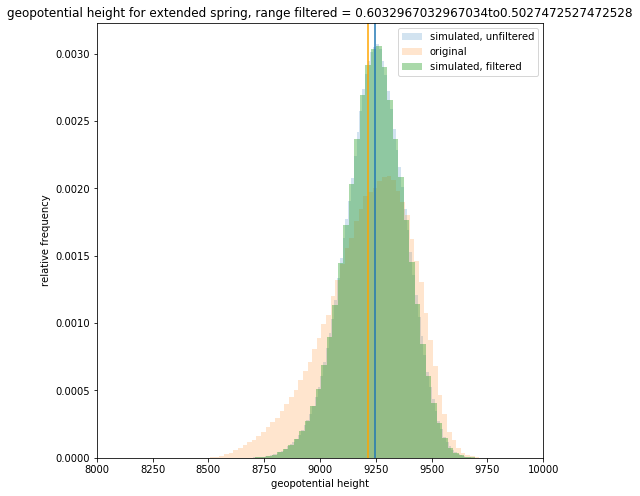

<Figure size 432x288 with 0 Axes>

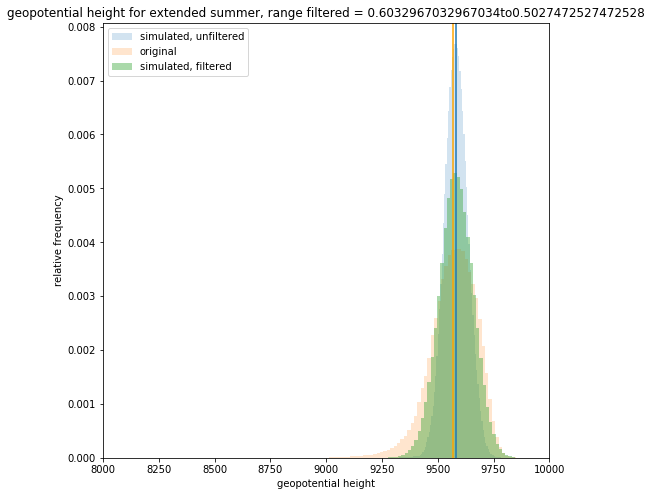

<Figure size 432x288 with 0 Axes>

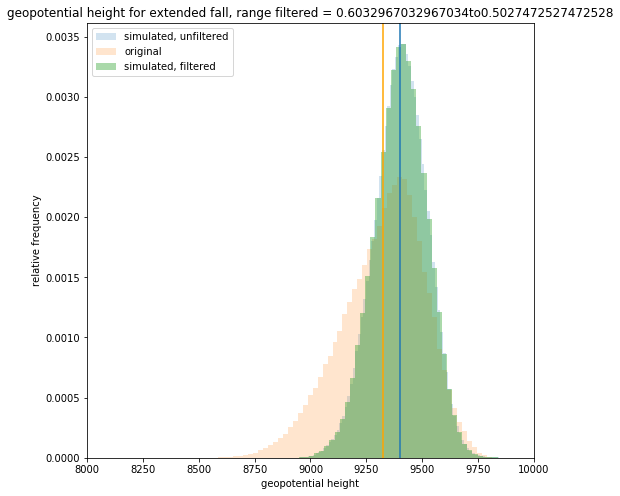

<Figure size 432x288 with 0 Axes>

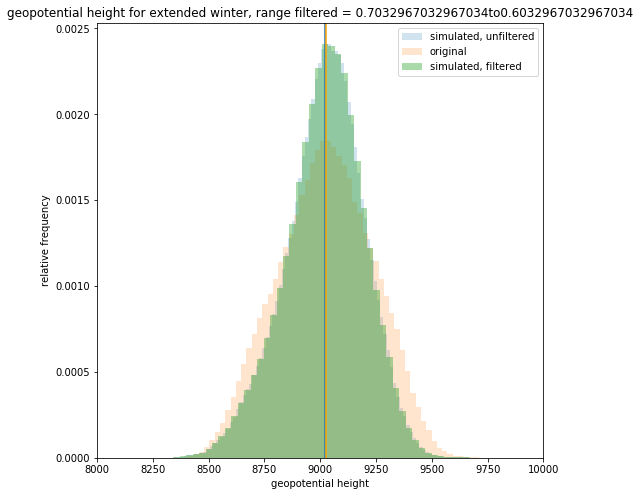

<Figure size 432x288 with 0 Axes>

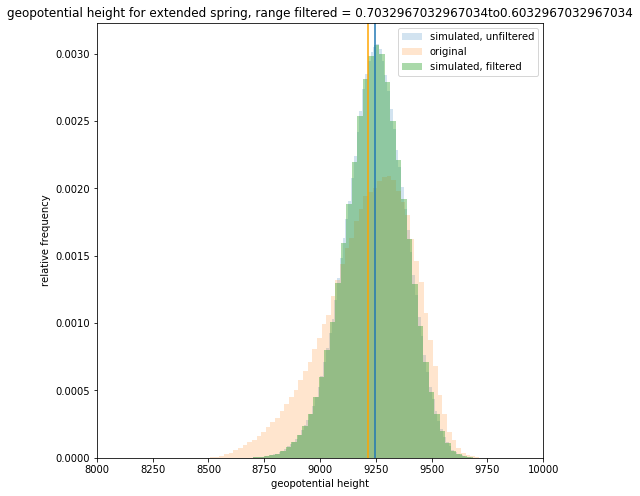

<Figure size 432x288 with 0 Axes>

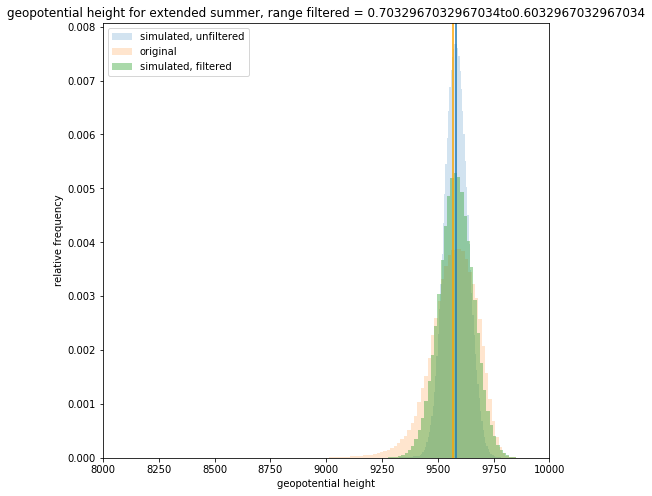

<Figure size 432x288 with 0 Axes>

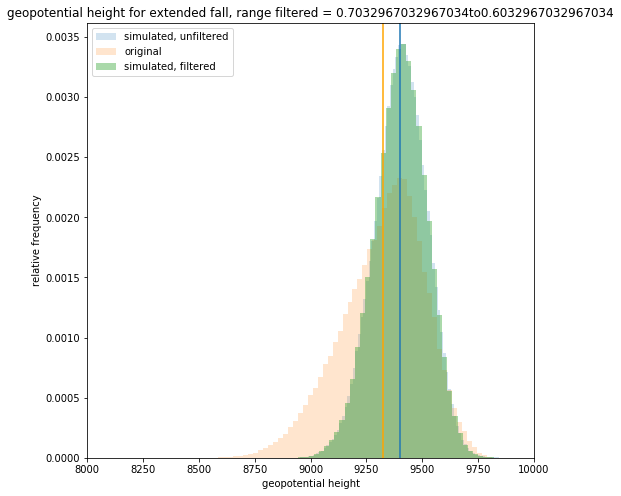

<Figure size 432x288 with 0 Axes>

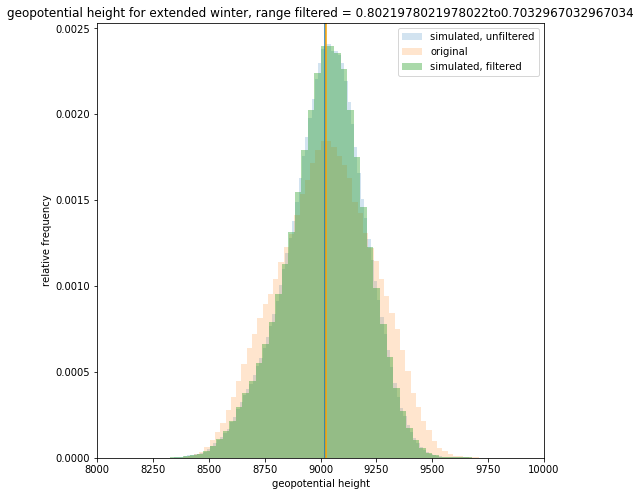

<Figure size 432x288 with 0 Axes>

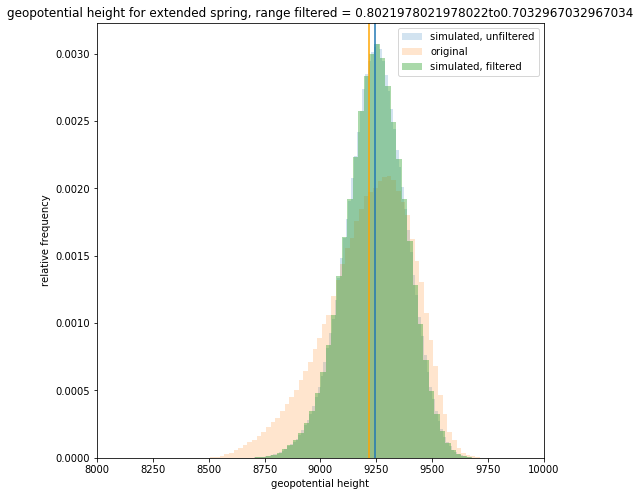

<Figure size 432x288 with 0 Axes>

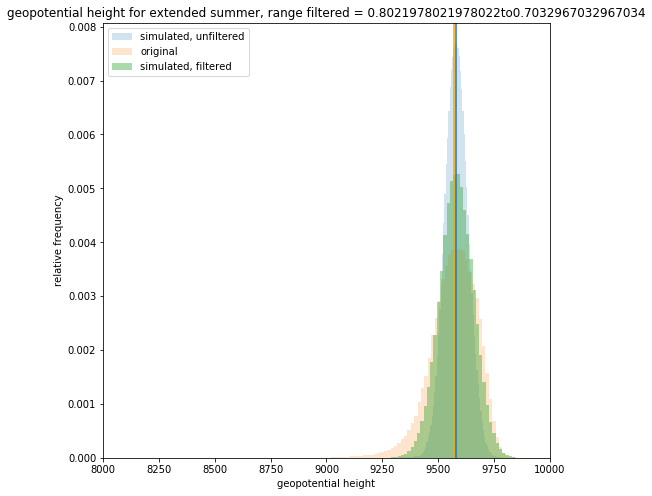

<Figure size 432x288 with 0 Axes>

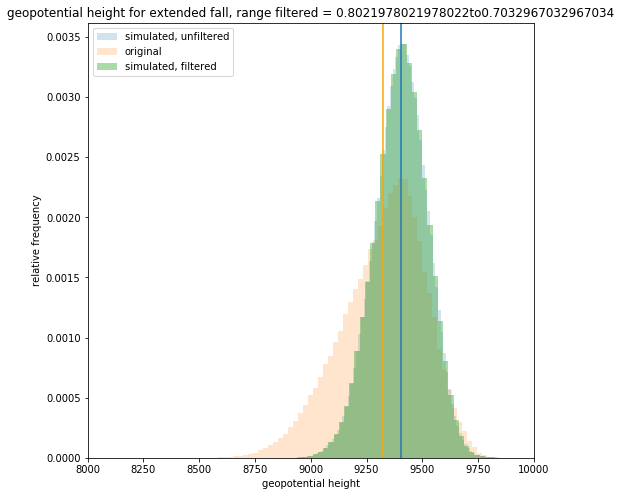

<Figure size 432x288 with 0 Axes>

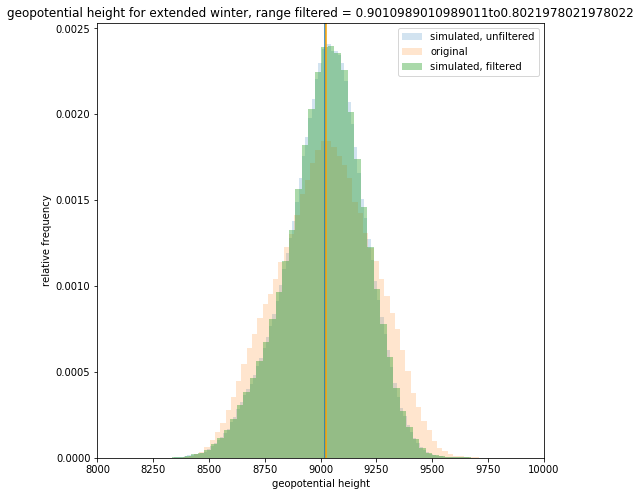

<Figure size 432x288 with 0 Axes>

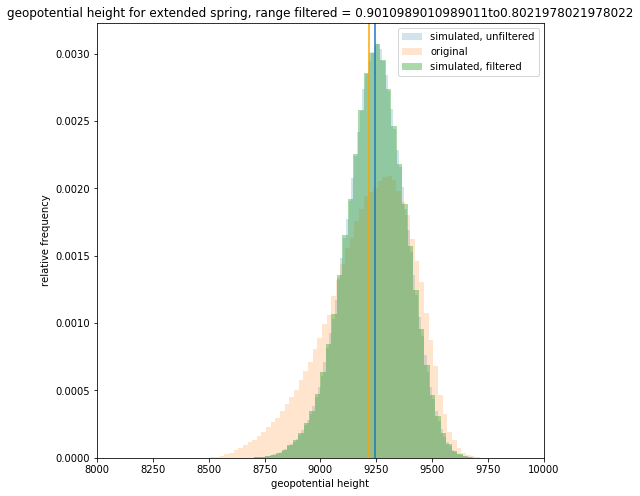

<Figure size 432x288 with 0 Axes>

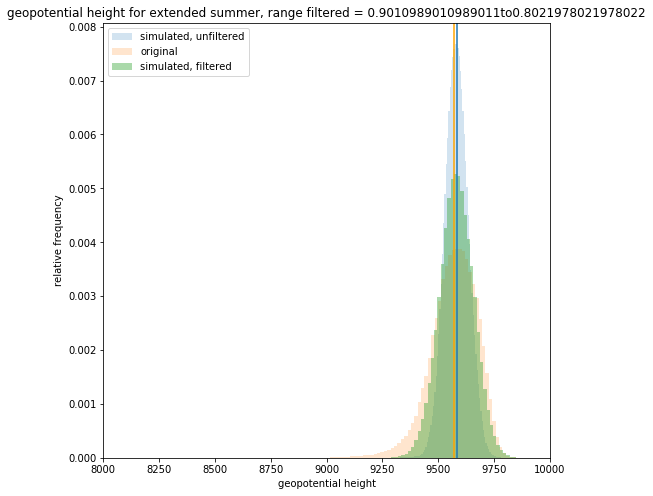

<Figure size 432x288 with 0 Axes>

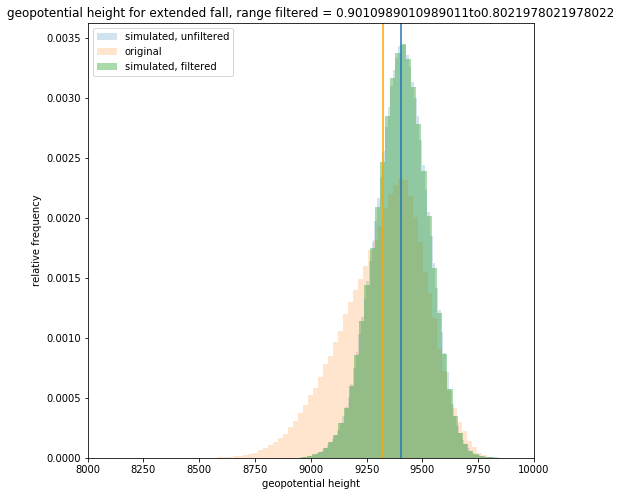

In [58]:
for j in range(3,10):
    upps = upper[j]
    lows = lower[j]

    return3 = [shorterf(entry, upps, lows, n = 400) for entry in edits]
    return3 = [np.real(entry) for entry in return3]

    for i in range(4):
        compare_filter(i, return3, upps, lows)
        rows_list.append(get_stats("filter_"+str(upps)+"to"+str(lows), return3[i], seasons[i]))

In [62]:
stats_df = pd.DataFrame(rows_list) 

In [63]:
stats_df.to_csv("nov18_sumstats.csv", encoding='utf-8')

<Figure size 432x288 with 0 Axes>

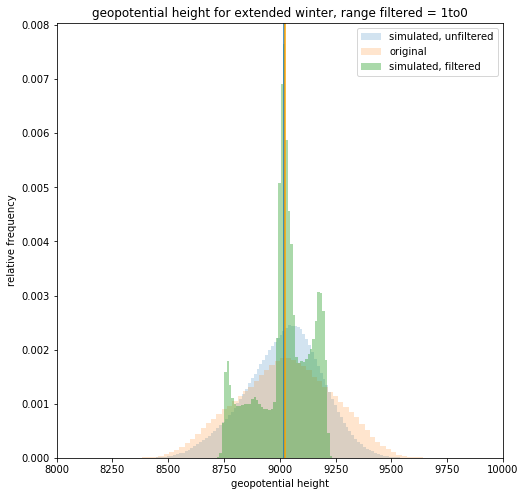

<Figure size 432x288 with 0 Axes>

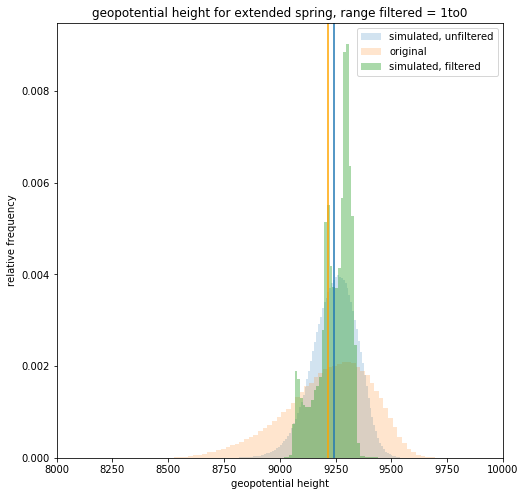

<Figure size 432x288 with 0 Axes>

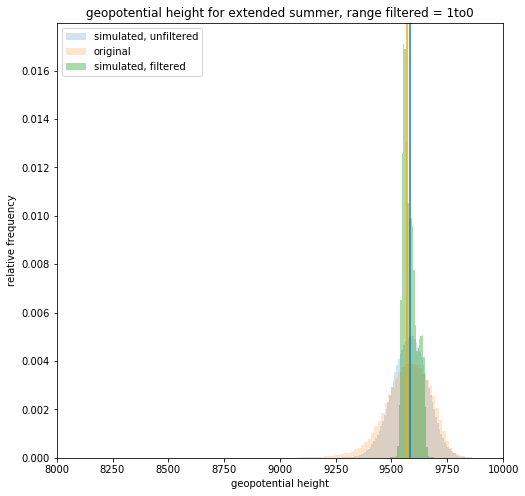

<Figure size 432x288 with 0 Axes>

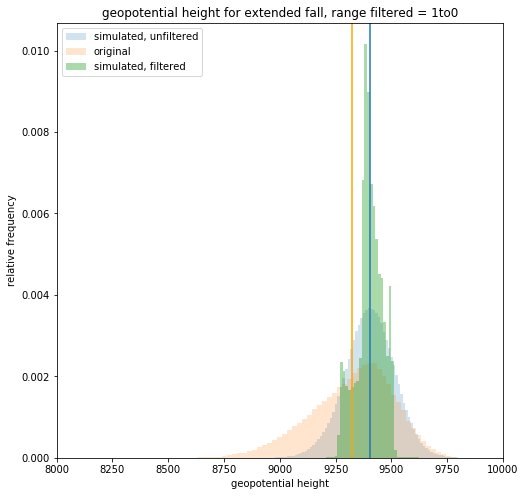

In [38]:
# so obviously this didn't work out
upps = upper[0]
lows = lower[0]

return4 = [shorterf(entry, upps, lows, n = 400) for entry in edits]
return4 = [np.real(entry) for entry in return4]

for i in range(4):
    compare_filter(i, return4, upps, lows)
    rows_list.append(get_stats("filter_"+str(upps)+"to"+str(lows), return4[i], seasons[i]))

In [39]:
stats_df = pd.DataFrame(rows_list) 


stats_df.to_csv("nov18_sumstats_02.csv", encoding='utf-8')

In [40]:
#try with larger ranges of percents?
#get filtering spectra
percents = [np.percentile(np.abs(approx_freqs), i*10) for i in range(0,6)]

upps = []
lows = []
for i in range(len(percents)- 1):
    upps.append(percents[i + 1])
    lows.append(percents[i])

In [41]:
stats_df = pd.DataFrame(rows_list) 


stats_df.to_csv("nov18_sumstats_03.csv", encoding='utf-8')

<Figure size 432x288 with 0 Axes>

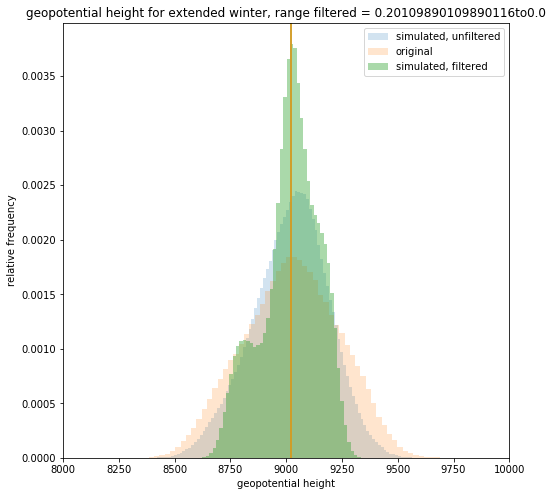

<Figure size 432x288 with 0 Axes>

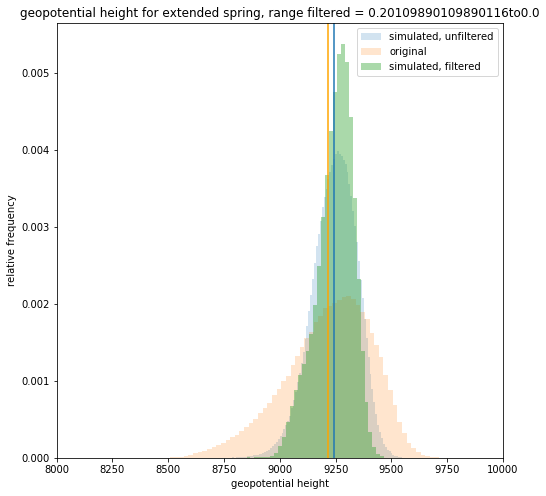

<Figure size 432x288 with 0 Axes>

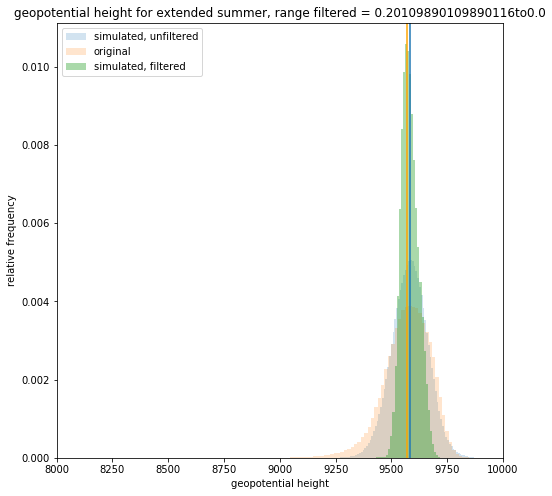

<Figure size 432x288 with 0 Axes>

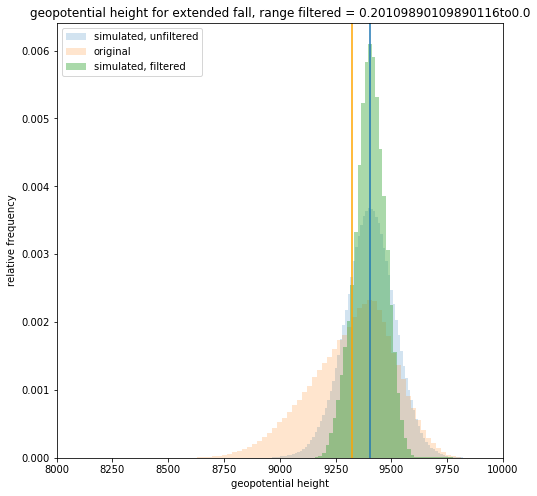

<Figure size 432x288 with 0 Axes>

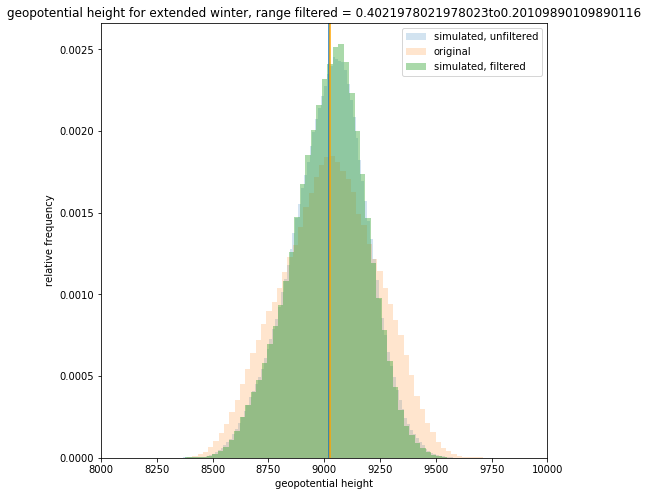

<Figure size 432x288 with 0 Axes>

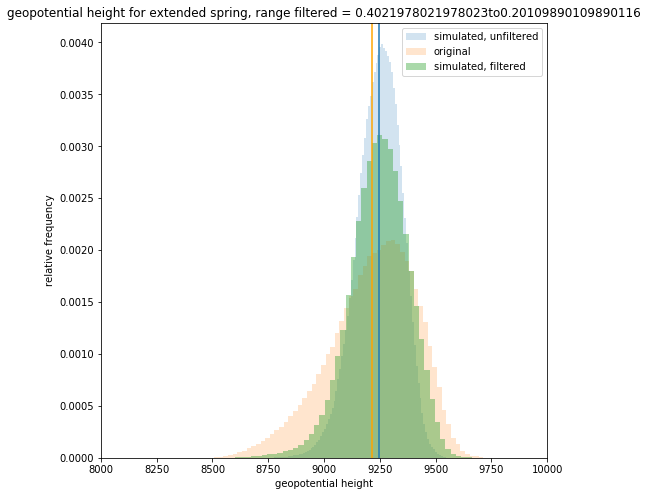

<Figure size 432x288 with 0 Axes>

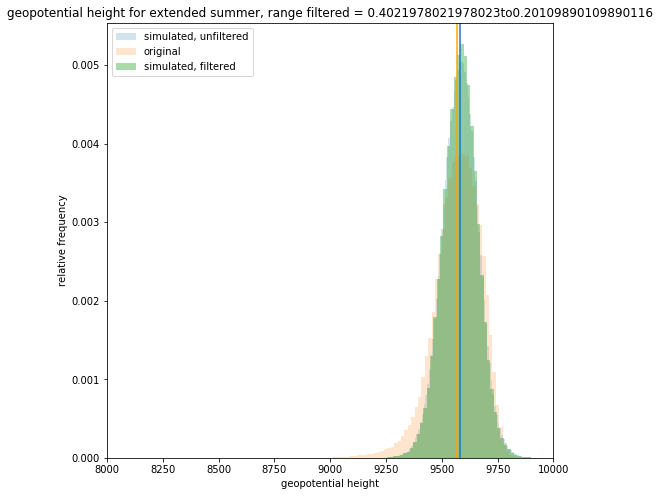

<Figure size 432x288 with 0 Axes>

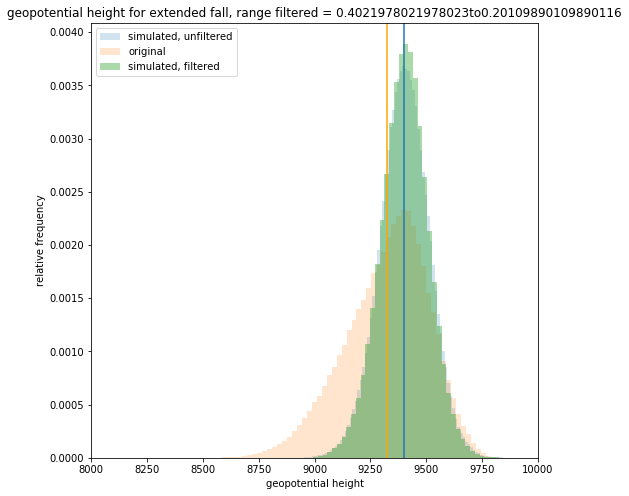

<Figure size 432x288 with 0 Axes>

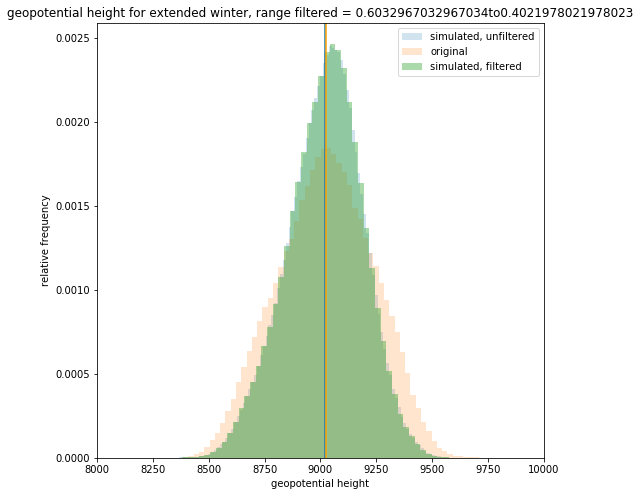

<Figure size 432x288 with 0 Axes>

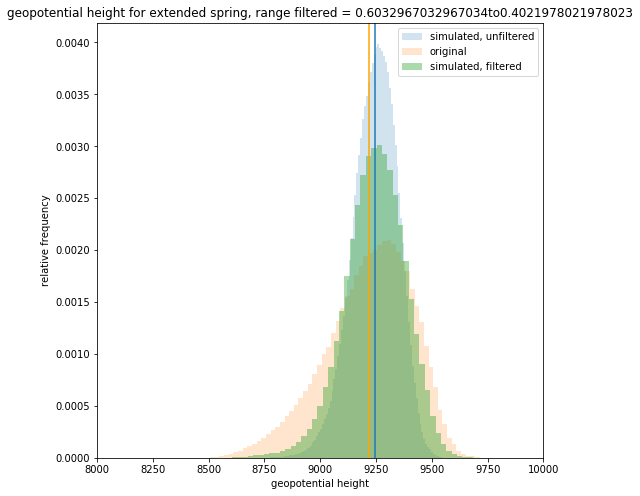

<Figure size 432x288 with 0 Axes>

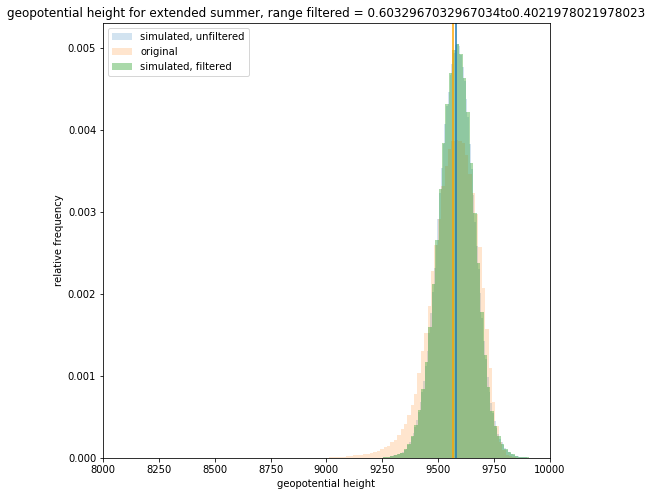

<Figure size 432x288 with 0 Axes>

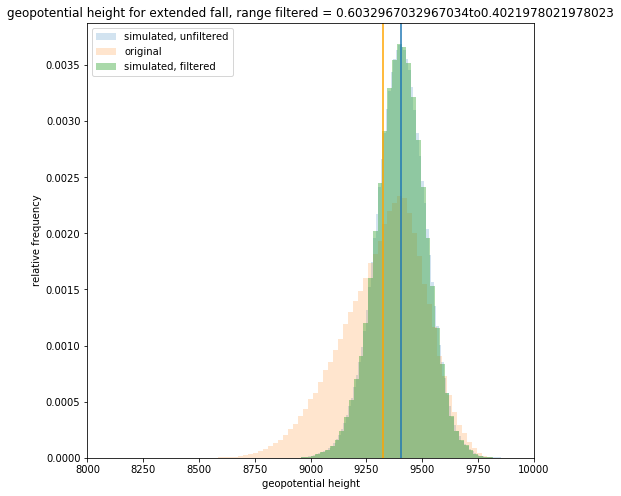

<Figure size 432x288 with 0 Axes>

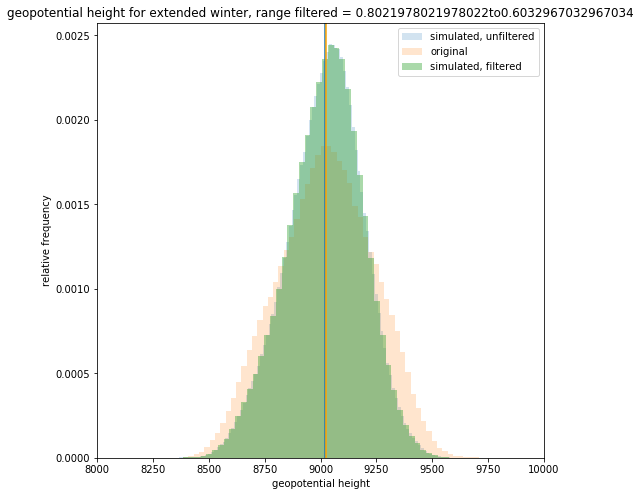

<Figure size 432x288 with 0 Axes>

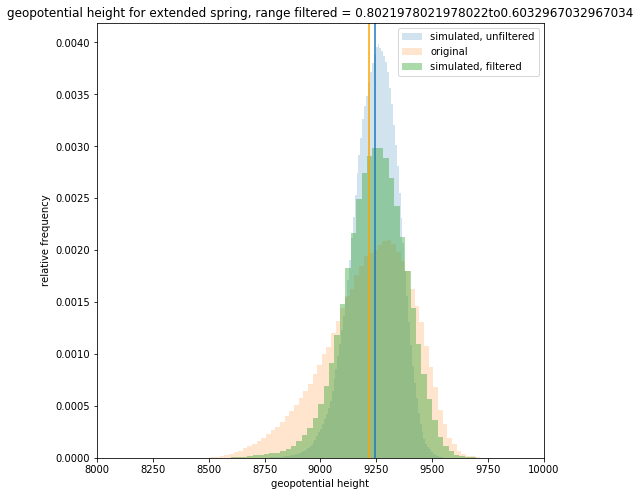

<Figure size 432x288 with 0 Axes>

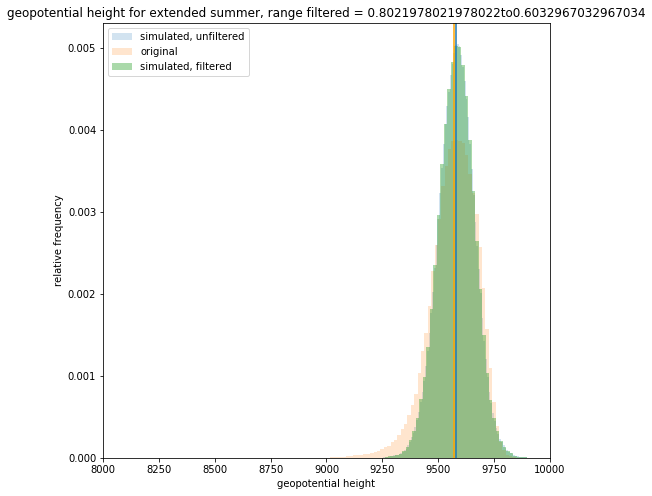

<Figure size 432x288 with 0 Axes>

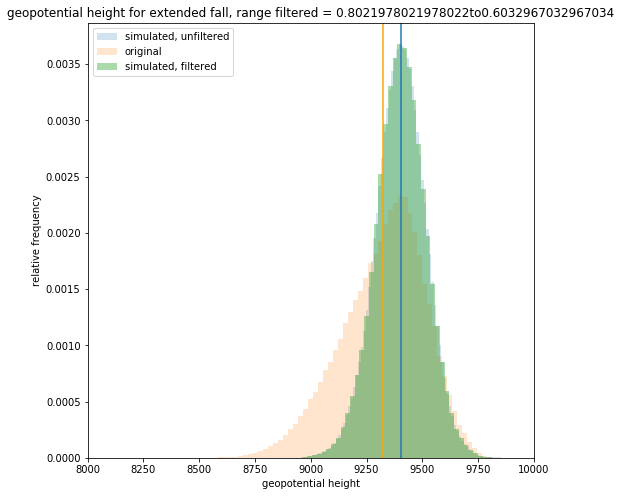

<Figure size 432x288 with 0 Axes>

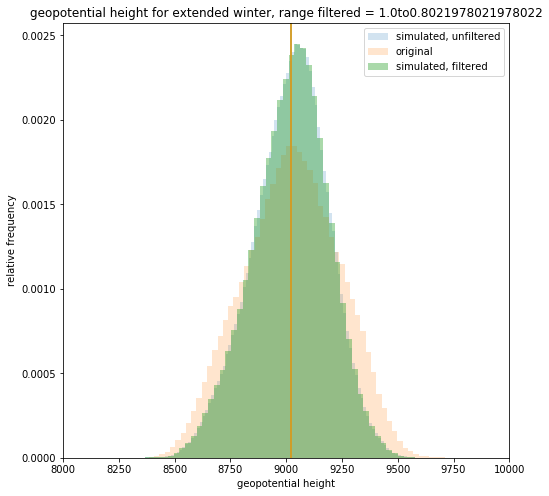

<Figure size 432x288 with 0 Axes>

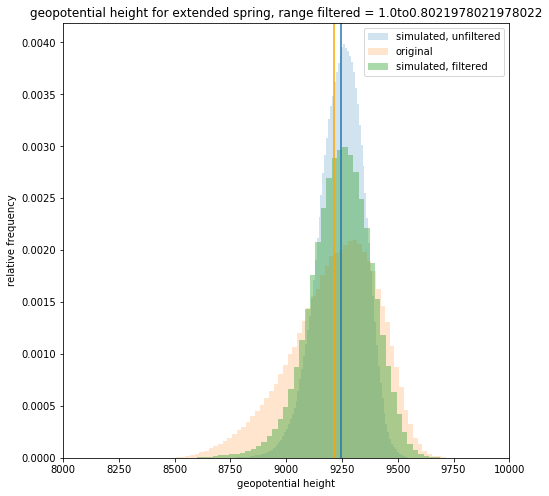

<Figure size 432x288 with 0 Axes>

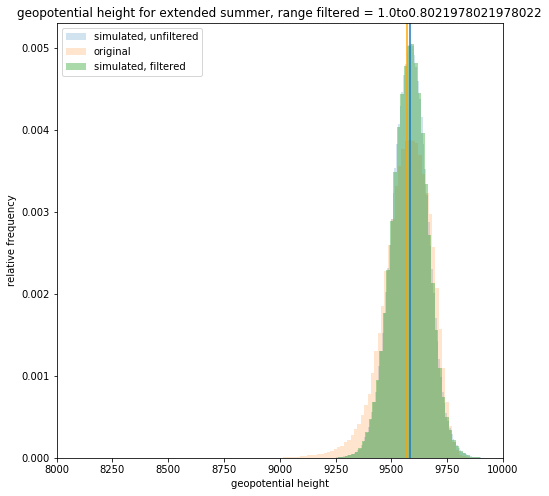

<Figure size 432x288 with 0 Axes>

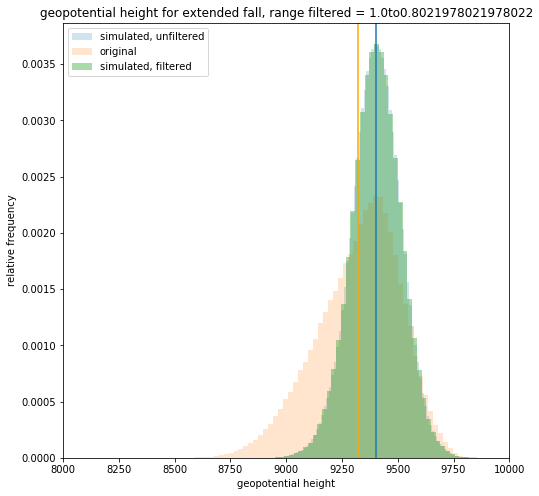

In [42]:
for i in range(len(upps)): 

    return5 = [shorterf(entry, upps[i], lows[i], n = 400) for entry in edits]
    return5 = [np.real(entry) for entry in return5]

    for j in range(4):
        compare_filter(j, return5, upps[i], lows[i])
        rows_list.append(get_stats("filter_"+str(upps[j])+"to"+str(lows[j]), return5[j], seasons[j]))

In [43]:
stats_df = pd.DataFrame(rows_list) 


stats_df.to_csv("nov18_sumstats_04.csv", encoding='utf-8')

In [44]:
#try with larger ranges of percents?
#get filtering spectra
percents = [np.percentile(np.abs(approx_freqs), i*5) for i in range(0,2)]

upps = []
lows = []
for i in range(len(percents)- 1):
    upps.append(percents[i + 1])
    lows.append(percents[i])

<Figure size 432x288 with 0 Axes>

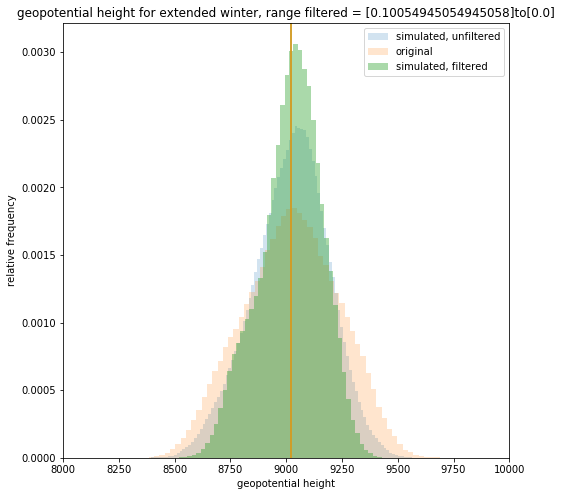

<Figure size 432x288 with 0 Axes>

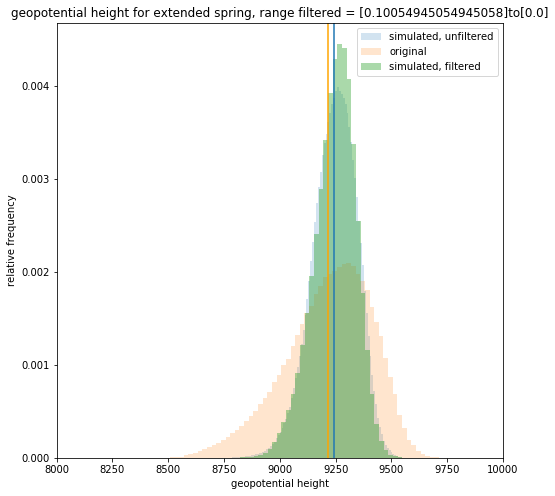

<Figure size 432x288 with 0 Axes>

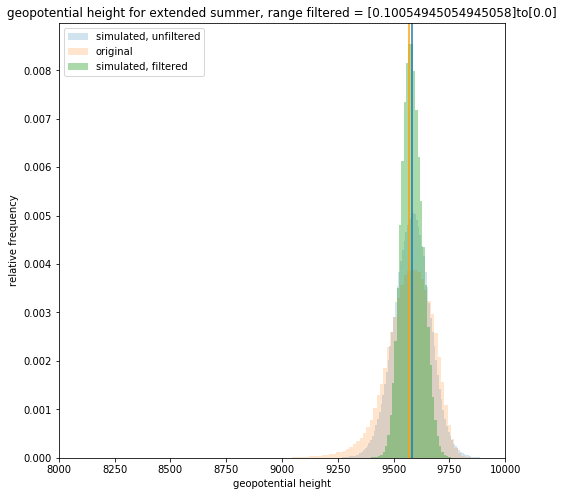

<Figure size 432x288 with 0 Axes>

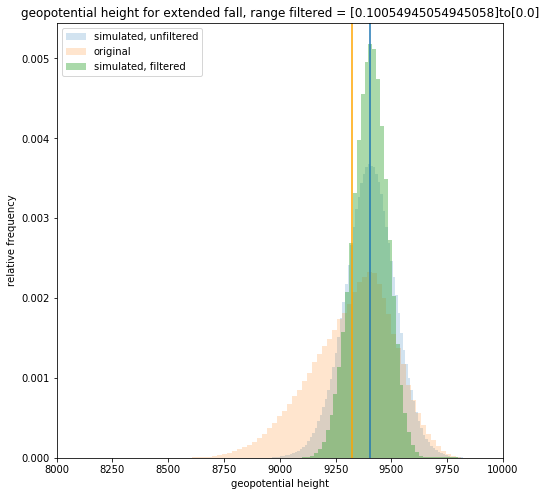

In [45]:
return4 = [shorterf(entry, upps, lows, n = 400) for entry in edits]
return4 = [np.real(entry) for entry in return4]

for i in range(4):
    compare_filter(i, return4, upps, lows)
    rows_list.append(get_stats("filter_"+str(upps)+"to"+str(lows), return4[i], seasons[i]))

In [46]:
stats_df = pd.DataFrame(rows_list) 

In [47]:
stats_df.to_csv("nov18_sumstats_05.csv", encoding='utf-8')

In [49]:
df1 = pd.read_csv('nov18_sumstats.csv')
df2 = pd.read_csv('nov18_sumstats_02.csv')
df3 = pd.read_csv('nov18_sumstats_03.csv')
df4 = pd.read_csv('nov18_sumstats_04.csv')
df5 = pd.read_csv('nov18_sumstats_05.csv')

In [53]:
df_tot = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df_tot.to_csv("nov18_sumstats_full.csv", encoding='utf-8')

## look at changes in variance

In [74]:
df = pd.read_csv('nov18_sumstats_full.csv')

In [78]:
##quick check -- to clean up later

df[:13]

df[4:5]["variance"]

nonoise = []
noise = []
observed = []

nonoise.append(df[:1]["variance"])
noise.append(df[4:5]["variance"])
observed.append(df[9:10]["variance"])

nonoise.append(df[1:2]["variance"])
noise.append(df[6:7]["variance"])
observed.append(df[10:11]["variance"])

nonoise.append(df[2:3]["variance"])
noise.append(df[7:8]["variance"])
observed.append(df[11:12]["variance"])

nonoise.append(df[3:4]["variance"])
noise.append(df[8:9]["variance"])
observed.append(df[12:13]["variance"])

nonoise = [float(entry) for entry in nonoise]
noise = [float(entry) for entry in noise]
observed = [float(entry) for entry in observed]

winter_diff = (observed[0] - nonoise[0])/observed[0]

winter_diff_noise = (observed[0] - noise[0])/observed[0]

spring_diff = (observed[1] - nonoise[1])/observed[1]

spring_diff_noise = (observed[1] - noise[1])/observed[1]

summer_diff =(observed[2] - nonoise[2])/observed[2]

summer_diff_noise =(observed[2] - noise[2])/observed[2]

fall_diff = (observed[3] - nonoise[3])/observed[3]

fall_diff_noise = (observed[3] - noise[3])/observed[3]